In [1]:
from IPython.display import display, Image, clear_output

# Comprehensive Lipidome Automation Workflow (CLAW)

Welcome to CLAW, a tool designed to facilitate and optimize the processing of lipidomic MRM data. This Jupyter notebook encapsulates a suite of tools that streamline the various stages of lipidomics data analysis.

Our toolset enables users to efficiently process MRM data files in the mzML format. Upload a file and CLAW will parse the data into a structured Pandas dataframe. This dataframe includes critical information like sample_ID, MRM transition, and signal intensity. Furthermore, our tool aligns each MRM transition with a default or custom lipid_database for accurate and swift annotation.

Moreover, CLAW is equipped with an OzESI option, a tool to elucidate the double bond location in lipid isomers. This feature allows users to input OzESI data and pinpoint the precise location of double bonds in isomeric lipids. Users have the flexibility to select which double bond locations they want to analyze. Following this, CLAW autonomously predicts potential m/z values and cross-references these predictions with sample data, ensuring a comprehensive and meticulous analysis.

With automation at its core, CLAW eliminates the need for manual data processing, significantly reducing time expenditure. It is a robust and invaluable tool for handling large volumes of lipid MRM data, accelerating scientific discovery in the field of lipidomics.

In [2]:
#Import all the necessary python libraries
import pymzml
import csv
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import json
from scipy.integrate import trapz

#Import all the necessary CLAW libraries
import create_directory
import CLAW
import matplotlib.pyplot as plt
import warnings

import re
from sklearn.mixture import GaussianMixture

# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Directory and File Management
For structured data management and efficient workflow, the system first ensures the presence of an output directory. If such a directory already exists you can skip this step.

In [3]:
# # Create the output directory. If it already exists you can skip this step.
# create_directory.create_project_folder()


The name of the project is defined next. This is important as the created directory will bear this name, allowing users to manage and identify their data with ease.

After the mzML files are uploaded to the designated mzML folder, the next block of code segregates these files based on their characteristics. More specifically, it filters the files and transfers them to respective folders named 'o3on' and 'o2only'.

In [4]:
name_of_project = 'FaceFats'
#After you load mzml files to mzml folder. this will filter the files and move them to o3on and o2only folders
create_directory.filter_o3mzml_files(name_of_project)

One or both of the destination directories 'Projects/FaceFats/o3on' and 'Projects/FaceFats/o2only' do not exist.


## Pre-Parsing Setup
The following block of code takes the preset variable values and uses them to parse the mzML files. The parsed data, including the sample ID, MRM transitions, and intensities, is stored in a pandas dataframe for easy manipulation and analysis.

The function CLAW.parsing_mzml_to_df takes several arguments. data_base_name_location is the location of the lipid database that contains information on lipid classes, fatty acid chains, and their corresponding MRM transitions. Project_Folder_data is the location of the mzML files for the samples to be analyzed. tolerance defines the acceptable range of deviation for the MRM transitions when matching them with the lipid database. The argument remove_std is a boolean that, when True, indicates to remove the MRM transitions that correspond to standards (internal or external) present in the samples.

The function outputs a pandas dataframe (df) where each row corresponds to an MRM transition detected in a sample, and columns include the sample ID, MRM transition, and intensity of the transition, among other values.

In [5]:
# Set default values
data_base_name_location = 'lipid_database/Lipid_Database.xlsx'
Project = './Projects/'
Project_Name = 'FaceFats'
Project_Folder_data = Project + Project_Name + '/mzml_liver_OzON/'
Project_results = Project + Project_Name + '/results/'
file_name_to_save = 'Liver_OzON'
tolerance = 0.3
remove_std = True
save_data = True

# Call pre_parsing_setup to initialize the variables
data_base_name_location, Project_Folder_data, Project_results, file_name_to_save, tolerance, remove_std, save_data = CLAW.pre_parsing_setup(data_base_name_location,
 Project, 
 Project_Name, 
 Project_Folder_data,
 Project_results, 
 file_name_to_save, 
 tolerance, 
 remove_std,
 save_data)


data_base_name_location: lipid_database/Lipid_Database.xlsx
Project: ./Projects/
Project_Name: FaceFats
Project_Folder_data: ./Projects/FaceFats/mzml_liver_OzON/
Project_results: ./Projects/FaceFats/results/
file_name_to_save: Liver_OzON
tolerance: 0.3
remove_std: True
save_data: True


Define the master dataframes where the data will be stored during the parsing step.

In [6]:
time_and_intensity_df, master_df, OzESI_time_df = CLAW.create_analysis_dataframes()

## CLAW.full_parse()
In this code, the `CLAW.full_parse()` function is used to analyze the MRM data. It takes several parameters like the location of the lipid database, paths to the data and results folders, the name of the result files, and the tolerance for MRM transitions matching. The function returns two dataframes: `df_matched` that contains information about each detected lipid species and their corresponding MRM transitions, and `OzESI_time_df` which captures data related to OzESI-MS scans, including potential double bond locations of lipids. If `remove_std` is `True`, it removes MRM transitions related to standards from the dataframe, and if `save_data` is `True`, the dataframe is saved as a .csv file in the specified results folder.

In [7]:
# Use the initialized variables as arguments to full_parse
df_MRM, df_OzESI = CLAW.full_parse(data_base_name_location, 
                                               Project_Folder_data, 
                                               Project_results, 
                                               file_name_to_save, 
                                               tolerance, 
                                               remove_std=True, 
                                               save_data=False,
                                               batch_processing=True,
                                               plot_chromatogram=False)

/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Parent_Ion'] = np.round(lipid_MRM_data['Parent_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Product_Ion'] = np.round(lipid_MRM_data['Product_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Finished parsing mzML file: ./Projects/FaceFats/mzml_liver_OzON/12012023_DOD73_M2_5xFAD_liver_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_liver_OzON/12012023_FAD131_M1_5xFAD_liver_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_liver_OzON/12012023_FAD131_M2_5xFAD_liver_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_liver_OzON/12012023_FAD131_M4_5xFAD_liver_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_liver_OzON/12012023_FAD173_M1_5xFAD_liver_O3on_01.mzML

Finished parsing all mzML files



In [8]:
df_MRM.head(None)

,Class,Intensity,Lipid,Parent_Ion,Product_Ion,Sample_ID,Transition
0,NaN,23873.981735,NaN,584.4,437.3,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
1,NaN,30013.202080,NaN,612.4,437.3,12012023_DOD73_M2_5xFAD_liver_O3on_01,612.4 -> 437.3
2,NaN,27567.021954,NaN,622.5,503.4,12012023_DOD73_M2_5xFAD_liver_O3on_01,622.5 -> 503.4
3,NaN,30535.462173,NaN,624.5,505.4,12012023_DOD73_M2_5xFAD_liver_O3on_01,624.5 -> 505.4
4,NaN,81457.065533,NaN,626.5,437.3,12012023_DOD73_M2_5xFAD_liver_O3on_01,626.5 -> 437.3
...,...,...,...,...,...,...,...
745,TAG,233716.696194,"[TG(57:9),TG(56:2)]_FA18:1",932.9,633.6,12012023_FAD173_M1_5xFAD_liver_O3on_01,932.9 -> 633.6
746,TAG,49685.523727,"[TG(58:7),TG(57:0)]_FA18:1",950.9,651.6,12012023_FAD173_M1_5xFAD_liver_O3on_01,950.9 -> 651.6
747,TAG,34257.062469,"[TG(59:13),TG(58:6)]_FA18:1",952.8,653.5,12012023_FAD173_M1_5xFAD_liver_O3on_01,952.8 -> 653.5
748,TAG,40613.842754,"[TG(59:12),TG(58:5)]_FA18:1",954.8,655.5,12012023_FAD173_M1_5xFAD_liver_O3on_01,954.8 -> 655.5


In [9]:
df_OzESI.head(None)
# df_OzESI.to_csv('FF_OzOFF_full.csv')
# df_OzESI.to_excel('FaceFatsOzdf.xlsx')

,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
0,NaN,584.4,437.3,0.044183,41.140003,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
1,NaN,584.4,437.3,0.088567,41.120003,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
2,NaN,584.4,437.3,0.132967,41.140003,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
3,NaN,584.4,437.3,0.177367,41.060001,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
4,NaN,584.4,437.3,0.221783,41.100002,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
...,...,...,...,...,...,...,...
422241,NaN,956.9,657.6,24.779117,41.080002,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6
422242,NaN,956.9,657.6,24.823533,40.980003,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6
422243,NaN,956.9,657.6,24.867933,40.980003,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6
422244,NaN,956.9,657.6,24.912333,40.960003,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6


The `read_mrm_list()` function is first invoked to read the MRM database from the specified file location and return it as a pandas DataFrame `mrm_database`. Subsequently, the `match_lipids_parser()` function is called to match the detected lipids from the `OzESI_time_df` DataFrame, obtained from the OzESI-MS scans, with the known lipids in the `mrm_database` based on the MRM transitions within the specified `tolerance`. The result is saved in the `df_oz_matched` DataFrame, which now contains matched lipid species from the OzESI-MS data.

In [10]:
d1 = df_OzESI.iloc[:,1:9]

# Assuming d1 is your DataFrame

# Define the retention time range as a tuple (lower_bound, upper_bound)
retention_time_range = (9.5, 21.5)  # Replace with your specific range values

# Filter the DataFrame to keep only rows where Retention_Time is within the specified range
d1a = d1[(d1['Retention_Time'] >= retention_time_range[0]) & (d1['Retention_Time'] <= retention_time_range[1])]

# # Now, filtered_d1 contains only the rows from d1 where Retention_Time is within the specified range
# filtered_d1.to_csv('filtered_d1_FF_OzON_Liver.csv')
d1a

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
213,584.4,437.3,9.502800,41.140003,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
214,584.4,437.3,9.547217,41.140003,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
215,584.4,437.3,9.591617,41.000004,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
216,584.4,437.3,9.636017,40.960003,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
217,584.4,437.3,9.680433,41.040005,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
...,...,...,...,...,...,...
422163,956.9,657.6,21.315367,41.180004,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6
422164,956.9,657.6,21.359783,41.060001,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6
422165,956.9,657.6,21.404183,41.240002,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6
422166,956.9,657.6,21.448600,41.240002,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6


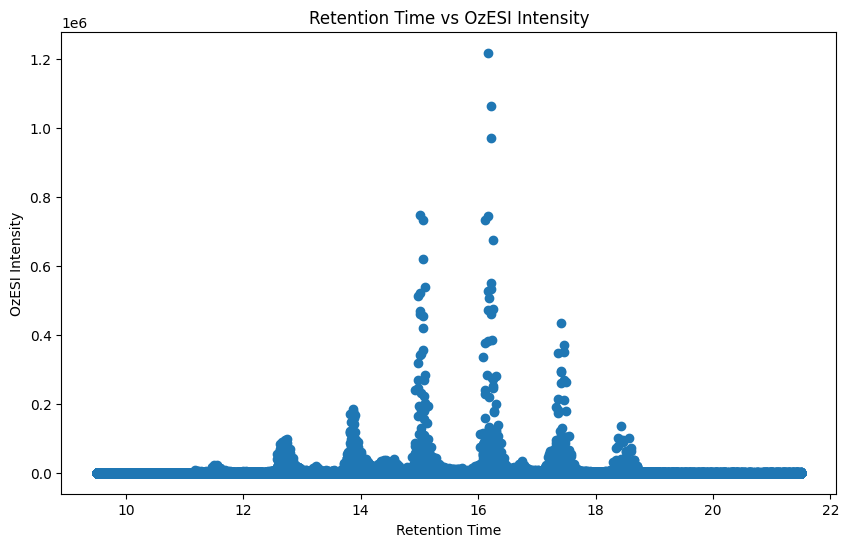

In [11]:


# Assuming clustered_data is your DataFrame with the necessary data

# Plotting the Intensity vs Retention Time
plt.figure(figsize=(10, 6))
plt.scatter(d1a['Retention_Time'], d1a['OzESI_Intensity'])

# Adding labels and title to the plot
plt.xlabel('Retention Time')
plt.ylabel('OzESI Intensity')
plt.title('Retention Time vs OzESI Intensity')

# Displaying the plot
plt.show()


Correct RTs add DB position based on correct RT

In [12]:
Correct_RT_directory = 'tools/RT/'
#MRM CORRECT RT DF
df_MRM_RT_correct = pd.read_csv(Correct_RT_directory + 'FF_MRM_CorrectRT_Liver_12dec23_v2.csv') #correct MRM RT
# df_MRM_RT_correct['Retention_Time'] = df_MRM_RT_correct['Average_Retention_Time']

# List of new column names based on db_pos_list
db_column_names = []
db_pos_list = [7, 9, 10, 12]


df_DB_aldehyde = pd.DataFrame(columns=['DB_Position','Aldehyde_Ion'])

# Loop through the range of DB_Position values to calculate the corresponding Aldehyde_Ion values
for position in range(3, 21):
    df_DB_aldehyde.loc[position, 'DB_Position'] = position
    df_DB_aldehyde.loc[position, 'Aldehyde_Ion'] = 26 + (14 * (position-3))

for number in db_pos_list:
    db_column_names.append(f'n-{number}')

# Create an empty DataFrame with initial columns
df_db_pos = pd.DataFrame(columns=['Lipid', 'Retention_Time', 'Parent_Ion','Product_Ion'])

# Append new column names to the DataFrame
for column_name in db_column_names:
    df_db_pos[column_name] = pd.NA  # Initialize the new columns with NA

# df_DB_aldehyde #aldehyde ion values


#append df_MRM_RT_correct to df_db_pos
df_db_pos = df_db_pos.append(df_MRM_RT_correct, ignore_index=True)


# Loop through the specified db_pos_list
for ozesi_position in db_pos_list:
    # Retrieve the corresponding Aldehyde_Ion value for the current DB_Position
    aldehyde_ion = df_DB_aldehyde.loc[df_DB_aldehyde["DB_Position"] == ozesi_position, "Aldehyde_Ion"].values[0]

    # Calculate and store the n-i value for the current OzESI position
    df_db_pos["n-{}".format(ozesi_position)] = df_db_pos["Parent_Ion"] - aldehyde_ion


# df_db_pos.to_csv('df_db_pos.csv')
# df_MRM_RT_correct  #correct MRM RT
#drop Average_Retention_Time column from df db pos
df_db_pos  #empty df with n-7, n-9, n-10, n-12 columns





,Lipid,Retention_Time,Parent_Ion,Product_Ion,n-7,n-9,n-10,n-12
0,[TG(50:3)]_FA18:1,14.00,846.8,547.5,764.8,736.8,722.8,694.8
1,[TG(52:5)]_FA16:1,12.75,870.8,599.5,788.8,760.8,746.8,718.8
2,"[TG(52:7),TG(51:0)]_FA18:1",17.06,866.8,567.5,784.8,756.8,742.8,714.8
3,[TG(54:5)]_FA18:1,13.91,898.8,599.5,816.8,788.8,774.8,746.8
4,[TG(54:6)]_FA18:1,12.80,896.8,597.5,814.8,786.8,772.8,744.8
5,"[TG(55:10),TG(54:3)]_FA18:1",16.26,902.8,603.5,820.8,792.8,778.8,750.8
6,"[TG(55:11),TG(54:4)]_FA16:1",15.01,900.8,629.5,818.8,790.8,776.8,748.8
7,"[TG(55:11),TG(54:4)]_FA18:1",15.10,900.8,601.5,818.8,790.8,776.8,748.8
8,"[TG(55:8),TG(54:1)]_FA18:1",18.61,906.8,607.5,824.8,796.8,782.8,754.8
9,"[TG(55:9),TG(54:2)]_FA18:1",17.50,904.8,605.5,822.8,794.8,780.8,752.8


Filter through filtered_d1 based on matched OzOFF lipids df_db_pos for n-7 and n-9 values

In [13]:
# Assuming df_db_pos and filtered_d1 are your DataFrames

tolerance = 0.3
retention_time_tolerance = 1.0  # Adjust this value as needed

# Re-initializing an empty DataFrame for filtered_d2
d2 = pd.DataFrame()

# Iterating through df_db_pos
for index, row in df_db_pos.iterrows():
    ground_truth_retention_time = row['Retention_Time']  # Ground truth retention time
    product_ion = row['Product_Ion']
    parent_ion_n7 = row['n-7']
    parent_ion_n9 = row['n-9']
    parent_ion_n10 = row['n-10']
    parent_ion_n12 = row['n-12']
    lipid_name = row['Lipid']  # Extracting Lipid name from df_db_pos

    # Defining the retention time window based on ground truth
    lower_bound_time = ground_truth_retention_time - retention_time_tolerance -0.3
    upper_bound_time = ground_truth_retention_time + retention_time_tolerance

    # Defining the tolerance for Parent and Product ions
    lower_bound_ion = product_ion - tolerance
    upper_bound_ion = product_ion + tolerance

    # Filtering filtered_d1 within the specified window and matching ions with tolerance
    matches = d1a[(d1a['Retention_Time'] >= lower_bound_time) & 
                        (d1a['Retention_Time'] <= upper_bound_time) &
                        (d1a['OzESI_Intensity'] >= 5) &
                        (d1a['Product_Ion'] >= lower_bound_ion) &
                        (d1a['Product_Ion'] <= upper_bound_ion)]

    # Adding 'db' and 'Lipid' columns based on the tolerance matching
    matches['db'] = ''
    matches['Lipid'] = lipid_name  # Adding the Lipid name to all matches
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n7 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n7 + tolerance), 'db'] = 'n-7'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n9 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n9 + tolerance), 'db'] = 'n-9'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n10 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n10 + tolerance), 'db'] = 'n-10'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n12 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n12 + tolerance), 'db'] = 'n-12'

    # Append the matching rows to filtered_d2
    d2 = d2.append(matches)

# Resetting the index of the new DataFrame
d2 = d2.reset_index(drop=True)

# Display the first few rows of the new DataFrame
d2


/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid
0,694.6,547.5,12.740950,187.020020,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1
1,694.6,547.5,12.785367,41.140003,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1
2,694.6,547.5,12.829767,41.180004,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1
3,694.6,547.5,12.874183,41.160004,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1
4,694.6,547.5,12.918583,231.780014,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1
...,...,...,...,...,...,...,...,...
37535,952.8,653.5,16.386817,41.180004,12012023_FAD173_M1_5xFAD_liver_O3on_01,952.8 -> 653.5,,"[TG(59:13),TG(58:6)]_FA18:1"
37536,952.8,653.5,16.431217,41.160004,12012023_FAD173_M1_5xFAD_liver_O3on_01,952.8 -> 653.5,,"[TG(59:13),TG(58:6)]_FA18:1"
37537,952.8,653.5,16.475633,41.200005,12012023_FAD173_M1_5xFAD_liver_O3on_01,952.8 -> 653.5,,"[TG(59:13),TG(58:6)]_FA18:1"
37538,952.8,653.5,16.520033,41.360004,12012023_FAD173_M1_5xFAD_liver_O3on_01,952.8 -> 653.5,,"[TG(59:13),TG(58:6)]_FA18:1"


Check specific transition RT for validate RT

In [14]:
# Assuming filtered_d2 is already created and contains the 'db' column

# Filter to get only the rows where 'db' is 'n-7'
n7_values = d2[d2['db'] == 'n-7']

# Filter to get only the rows with specific transition: Parent_Ion 788.7 to Product_Ion 599.5
specific_transition = n7_values[(n7_values['Parent_Ion'] == 790.7) & (n7_values['Product_Ion'] == 573.6)]

specific_transition


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid


Filter for only db values

In [15]:
# Creating filtered_d3 from filtered_d2
d3 = d2.copy()

# Dropping rows where 'db' column is blank
d3 = d3[d3['db'] != '']

# Alternatively, you can use:
# filtered_d3 = filtered_d3.dropna(subset=['db'])

d3


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid
0,694.6,547.5,12.740950,187.020020,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1
1,694.6,547.5,12.785367,41.140003,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1
2,694.6,547.5,12.829767,41.180004,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1
3,694.6,547.5,12.874183,41.160004,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1
4,694.6,547.5,12.918583,231.780014,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1
...,...,...,...,...,...,...,...,...
37483,870.7,653.5,16.393767,115.780006,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1"
37484,870.7,653.5,16.438167,41.140003,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1"
37485,870.7,653.5,16.482567,40.840004,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1"
37486,870.7,653.5,16.526983,41.120003,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1"


CLUSTER GMM

In [16]:


# # Assuming filtered_d2 is your DataFrame
# clustered_data = pd.DataFrame()  # Initialize an empty DataFrame to store clustered results

# # Iterate over each group of Parent_Ion and Product_Ion
# for (parent_ion, product_ion), group in filtered_d2.groupby(['Parent_Ion', 'Product_Ion']):
#     # Calculate 1% below the maximum 'OzESI_Intensity'
#     max_intensity = group['OzESI_Intensity'].max()
#     cutoff_intensity = max_intensity * 0.01

#     # Apply the filters
#     filtered_group = group[(group['OzESI_Intensity'] >= cutoff_intensity) & (group['OzESI_Intensity'] > 500)]

#     # Check if the filtered group is empty, skip to the next iteration if so
#     if filtered_group.empty:
#         continue

#     # Reshape the 'Retention_Time' data for GMM
#     retention_times = filtered_group[['Retention_Time']].values

#     # Apply GMM clustering to this specific ion pair group
#     # Note: The number of components (n_components) and the covariance type are parameters
#     # that might need tuning based on your specific dataset
#     gmm = GaussianMixture(n_components=1, covariance_type='full').fit(retention_times)

#     # Get the cluster labels
#     labels = gmm.predict(retention_times)

#     # Add the cluster labels to the filtered group
#     filtered_group['Cluster_Label'] = labels

#     # Append the clustered group to the results DataFrame
#     clustered_data = pd.concat([clustered_data, filtered_group])

# # The resulting DataFrame, clustered_data, now contains separately clustered data for each ion pair
# clustered_data


# GMM

In [17]:


# Assuming filtered_d2 is your DataFrame
d4 = pd.DataFrame()  # Initialize an empty DataFrame to store clustered results

# Iterate over each group of Parent_Ion and Product_Ion
for (parent_ion, product_ion, db), group in d3.groupby(['Parent_Ion', 'Product_Ion','db']):
    # Calculate 1% below the maximum 'OzESI_Intensity'
    max_intensity = group['OzESI_Intensity'].max()
    cutoff_intensity = max_intensity * 0.00005

    # Apply the filters
    filtered_group = group[(group['OzESI_Intensity'] >= cutoff_intensity) & (group['OzESI_Intensity'] > 0)]

    # Check if the filtered group is empty or has less than 2 samples
    if filtered_group.empty or len(filtered_group) < 2:
        continue

    # Reshape the 'Retention_Time' data for GMM
    retention_times = filtered_group[['Retention_Time']].values

    # Apply GMM clustering to this specific ion pair group
    # Note: Adjust the number of components (n_components) as needed
    gmm = GaussianMixture(n_components=3, covariance_type='full').fit(retention_times)

    # Get the cluster labels
    labels = gmm.predict(retention_times)

    # Add the cluster labels to the filtered group
    filtered_group['Cluster_Label'] = labels

    # Append the clustered group to the results DataFrame
    d4 = pd.concat([d4, filtered_group])

# The resulting DataFrame, clustered_data, now contains separately clustered data for each ion pair
d4


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label
0,694.6,547.5,12.740950,187.020020,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1
1,694.6,547.5,12.785367,41.140003,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1
2,694.6,547.5,12.829767,41.180004,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1
3,694.6,547.5,12.874183,41.160004,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1
4,694.6,547.5,12.918583,231.780014,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1
...,...,...,...,...,...,...,...,...,...
34883,874.8,657.6,18.035917,41.020004,12012023_FAD173_M1_5xFAD_liver_O3on_01,874.8 -> 657.6,n-7,"[TG(59:11),TG(58:4)]_FA18:1",2
34884,874.8,657.6,18.080317,41.220001,12012023_FAD173_M1_5xFAD_liver_O3on_01,874.8 -> 657.6,n-7,"[TG(59:11),TG(58:4)]_FA18:1",2
34885,874.8,657.6,18.124717,224.260010,12012023_FAD173_M1_5xFAD_liver_O3on_01,874.8 -> 657.6,n-7,"[TG(59:11),TG(58:4)]_FA18:1",2
34886,874.8,657.6,18.169133,178.900009,12012023_FAD173_M1_5xFAD_liver_O3on_01,874.8 -> 657.6,n-7,"[TG(59:11),TG(58:4)]_FA18:1",2


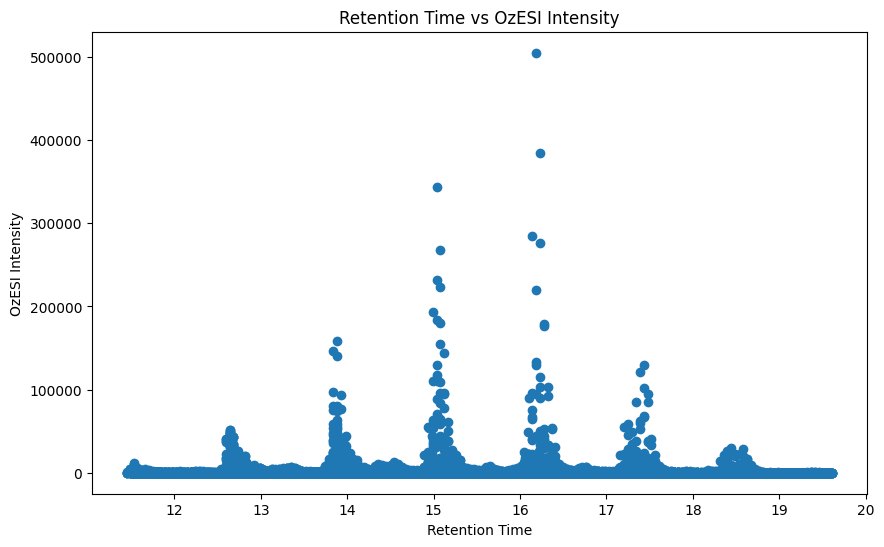

In [18]:


# Assuming clustered_data is your DataFrame with the necessary data

# Plotting the Intensity vs Retention Time
plt.figure(figsize=(10, 6))
plt.scatter(d4['Retention_Time'], d4['OzESI_Intensity'])

# Adding labels and title to the plot
plt.xlabel('Retention Time')
plt.ylabel('OzESI Intensity')
plt.title('Retention Time vs OzESI Intensity')

# Displaying the plot
plt.show()


# Determine Biology and Genotype

In [19]:
# Function to determine the value for the Biology and Genotype column
def extract_biology(sample_id):
    for term in ["liver", "cortex", "cereb", "hippo", "dienc"]:
        if term in sample_id.lower():
            return term
    return None

# Apply the function to the Sample_ID column to create the Biology and Genotype column
d4['Biology'] = d4['Sample_ID'].apply(extract_biology)
d4['Genotype'] = d4['Sample_ID'].apply(lambda x: '5xFAD' if 'WT' not in x else 'WT')
d4

# Function to remove the first TG if there are two TGs
def remove_first_tg(lipid):
    tg_parts = lipid.split(',')
    if len(tg_parts) > 1:
        return '[' + tg_parts[1]
    else:
        return lipid
    
# Function to determine the value for the FAC column
def determine_fac(lipid):
    if 'FA18:1' in lipid:
        return 'FA18:1'
    elif 'FA16:1' in lipid:
        return 'FA16:1'
    else:
        return None  # or some other default value

# Apply the function to the Lipid column to create the FAC column
d4['FAC'] = d4['Lipid'].apply(determine_fac)



# Function to extract TG values
def extract_tg(lipid):
    # Regular expression pattern to match TG(##:#) or similar patterns
    pattern = r'TG\(\d+:\d+\)'
    matches = re.findall(pattern, lipid)
    return ', '.join(matches) if matches else None

# Apply the function to the Lipid column to create the TG column
d4['TG'] = d4['Lipid'].apply(extract_tg)




# Function to sort TG values within a cell
def sort_tg_values(tg_cell):
    if not pd.isna(tg_cell) and ', ' in tg_cell:
        tg_list = tg_cell.split(', ')
        tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
        return ', '.join(tg_list_sorted)
    else:
        return tg_cell

# Apply the function to the TG column
d4['TG'] = d4['TG'].apply(sort_tg_values)
d4 = d4.sort_values(by=['FAC', 'TG'])

# Apply the function to the Lipid column
d4['Lipid'] = d4['Lipid'].apply(remove_first_tg)


# Sorting by 'Biology and Genotype' and then by 'Lipid'
d4 = d4.sort_values(by=['Biology','Genotype', 'Lipid'])

grouped_cluster_data = d4.groupby(['Lipid','db','Biology','Genotype','Transition','Sample_ID'])
#add group number to each to a new column called Group
d4['Group'] = grouped_cluster_data.ngroup()
d4
d5= d4.copy()  # Create a copy of the clustered_data DataFrame
#print transition 870.8 -> 788.8
d5

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group
0,694.6,547.5,12.740950,187.020020,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5
1,694.6,547.5,12.785367,41.140003,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5
2,694.6,547.5,12.829767,41.180004,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5
3,694.6,547.5,12.874183,41.160004,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5
4,694.6,547.5,12.918583,231.780014,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37483,870.7,653.5,16.393767,115.780006,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,[TG(58:6)]_FA18:1,1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454
37484,870.7,653.5,16.438167,41.140003,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,[TG(58:6)]_FA18:1,1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454
37485,870.7,653.5,16.482567,40.840004,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,[TG(58:6)]_FA18:1,1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454
37486,870.7,653.5,16.526983,41.120003,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,[TG(58:6)]_FA18:1,1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454


# Find max intensity

In [20]:
d6 = d5.copy()
# Group by 'Group' and 'Cluster_Label' and find the maximum 'OzESI_Intensity' for each group
max_intensity_group = d5.groupby(['Group', 'Cluster_Label'])['OzESI_Intensity'].max().reset_index()

# Rename the column to 'Max_Intensity'
max_intensity_group = max_intensity_group.rename(columns={'OzESI_Intensity': 'Max_Intensity'})

# Merge the maximum intensity data back into the original DataFrame
d6 = d6.merge(max_intensity_group, on=['Group', 'Cluster_Label'])
#round max intensity to 0 decimal places
d6['Max_Intensity'] = d6['Max_Intensity'].round(0)
# Display the DataFrame
d6


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity
0,694.6,547.5,12.740950,187.020020,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0
1,694.6,547.5,12.785367,41.140003,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0
2,694.6,547.5,12.829767,41.180004,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0
3,694.6,547.5,12.874183,41.160004,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0
4,694.6,547.5,12.918583,231.780014,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26895,870.7,653.5,16.393767,115.780006,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,[TG(58:6)]_FA18:1,1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454,116.0
26896,870.7,653.5,16.438167,41.140003,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,[TG(58:6)]_FA18:1,1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454,116.0
26897,870.7,653.5,16.482567,40.840004,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,[TG(58:6)]_FA18:1,1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454,116.0
26898,870.7,653.5,16.526983,41.120003,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,[TG(58:6)]_FA18:1,1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454,116.0


# Match cluster to ground truth RT

In [21]:


# Assuming d6 DataFrame is already defined
d7 = d6.copy()

# Adding Cluster_RT column to d7 using Max_Intensity values
d7['Cluster_RT'] = d7.groupby(['Lipid', 'Sample_ID', 'db'])['Max_Intensity'].transform('idxmax').map(d7['Retention_Time'])

# Rounding Cluster_RT to 2 decimal places
d7['Cluster_RT'] = d7['Cluster_RT'].round(2)

###########

# Assuming d8 is already defined
d8 = d7.copy()

# Create a mapping from Lipid to ground truth Retention_Time
ground_truth_rt = dict(zip(df_db_pos['Lipid'], df_db_pos['Retention_Time']))

# Calculate the distance to the ground truth for each row in d8
d8['distance_to_truth'] = d8.apply(lambda row: abs(row['Retention_Time'] - ground_truth_rt.get(row['Lipid'], np.nan)), axis=1)

# Filter out rows with NaN in 'distance_to_truth'
d8_filtered = d8.dropna(subset=['distance_to_truth'])

# Function to keep all rows of the group with the closest Cluster_Label to the ground truth
def keep_group_with_closest_cluster(group):
    idx_min_distance = group['distance_to_truth'].idxmin()
    closest_cluster_label = group.loc[idx_min_distance, 'Cluster_Label']
    return group[group['Cluster_Label'] == closest_cluster_label]

# Apply the function to each group in the filtered DataFrame
df_true = d8_filtered.groupby('Group').apply(keep_group_with_closest_cluster).reset_index(drop=True)

# Displaying the updated DataFrame
df_true

d9 = df_true.copy()    
d9


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth
0,722.7,547.5,13.538800,40.980003,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.461200
1,722.7,547.5,13.583200,41.040005,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.416800
2,722.7,547.5,13.627617,40.900002,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.372383
3,722.7,547.5,13.672017,40.880001,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.327983
4,722.7,547.5,13.716417,41.060001,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.283583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,814.7,625.5,14.449917,5175.280273,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.019917
2056,814.7,625.5,14.494317,2062.900146,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.064317
2057,814.7,625.5,14.538717,517.380066,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.108717
2058,814.7,625.5,14.583133,129.980011,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.153133


# Keep Cluster with highest max intensity, remove other clusters

In [22]:
d10 = d9.copy()
# Step 1: Identify the Cluster_Label with the highest Max_Intensity for each Group
max_intensity_label_per_group = d10.groupby('Group').apply(lambda x: x['Cluster_Label'][x['Max_Intensity'].idxmax()])

# Step 2: Filter the original DataFrame
d10 = d10[d10.apply(lambda row: row['Cluster_Label'] == max_intensity_label_per_group[row['Group']], axis=1)]

# Filter out group-cluster pairs where the maximum intensity (Max_Intensity) is 500 or less
valid_pairs = d10[d10['Max_Intensity'] > 300]

# The resulting DataFrame, valid_pairs, now contains data for group-cluster pairs meeting the intensity criterion
d10 = valid_pairs

# Display the filtered DataFrame
d10



,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth
0,722.7,547.5,13.538800,40.980003,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.461200
1,722.7,547.5,13.583200,41.040005,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.416800
2,722.7,547.5,13.627617,40.900002,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.372383
3,722.7,547.5,13.672017,40.880001,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.327983
4,722.7,547.5,13.716417,41.060001,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.283583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,814.7,625.5,14.449917,5175.280273,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.019917
2056,814.7,625.5,14.494317,2062.900146,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.064317
2057,814.7,625.5,14.538717,517.380066,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.108717
2058,814.7,625.5,14.583133,129.980011,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.153133


In [23]:


# # Assuming 'd7' is the DataFrame and already defined
# # Extracting data for Group 10
# group_10_data = d7[d7['Group'] == 15]
# group_10_data
# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(group_10_data['Retention_Time'], group_10_data['OzESI_Intensity'])
# plt.xlabel('Retention Time')
# plt.ylabel('OzESI Intensity')
# plt.title('Plot for Group 10')
# plt.show()



# Set Peak Boundaries using Peak Width at % of Peak Height

In [51]:
# Assuming d7 is already defined
d11 = d10.copy()

# Define the directory where you want to save the plots
save_directory = 'Projects/FaceFats/plots/peak_check/width/'
os.makedirs(save_directory, exist_ok=True)

# Setting parameters for peak finding
peak_width_fraction = 0.03
peak_width_fraction_large = 0.01
peak_width_intensity_threshold = 2000

# Function to calculate peak boundaries
def calculate_peak_boundaries(intensities, times, peak_max_index):
    peak_max_intensity = intensities[peak_max_index]
    if peak_max_intensity > peak_width_intensity_threshold:
        intensity_threshold = peak_max_intensity * peak_width_fraction_large
    else:
        intensity_threshold = peak_max_intensity * peak_width_fraction

    left_indices = np.where(intensities[:peak_max_index] < intensity_threshold)[0]
    right_indices = np.where(intensities[peak_max_index:] < intensity_threshold)[0] + peak_max_index

    peak_start = times[left_indices[-1]] if len(left_indices) > 0 else times[0]
    peak_end = times[right_indices[0]] if len(right_indices) > 0 else times[-1]

    return peak_start, peak_end

def plot_peak_and_boundaries(group_data, group, cluster_label, save_dir, peak_width_fraction=0.2):
    
    times = group_data['Retention_Time'].values
    intensities = group_data['OzESI_Intensity'].values
    peak_max_index = np.argmax(intensities)
    peak_max_intensity = intensities[peak_max_index]
    print(peak_max_intensity)
    peak_start, peak_end = calculate_peak_boundaries(intensities, times, peak_max_index)

    # Extract additional information for the title
    lipid = group_data.iloc[0]['Lipid']
    biology = group_data.iloc[0]['Biology']
    genotype = group_data.iloc[0]['Genotype']
    db = group_data.iloc[0]['db']
    sample_id = group_data.iloc[0]['Sample_ID']

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(times, intensities, label='Intensity')
    plt.scatter(times[peak_max_index], intensities[peak_max_index], color='red', label='Peak', zorder=5)
    if peak_max_intensity > peak_width_intensity_threshold:
        plt.axvline(peak_start, color='green', linestyle='--', label=f'Peak Start (Width at {peak_width_fraction_large*100:.0f}%)')
        plt.axvline(peak_end, color='blue', linestyle='--', label=f'Peak End (Width at {peak_width_fraction_large*100:.0f}%)')
    else:
        plt.axvline(peak_start, color='green', linestyle='--', label=f'Peak Start (Width at {peak_width_fraction*100:.0f}%)')
        plt.axvline(peak_end, color='blue', linestyle='--', label=f'Peak End (Width at {peak_width_fraction*100:.0f}%)')
    plt.xlabel('Retention Time')
    plt.ylabel('OzESI Intensity')
    plt.title(f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}')
    plt.legend()

    filename = f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}.png'
    # plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
    # plt.show()
    plt.close()

# Iterating over groups and clusters and plotting peaks
for (group, cluster_label), group_df in d11.groupby(['Group', 'Cluster_Label']):
    group_df_sorted = group_df.sort_values(by='Retention_Time')
    peak_max_index = np.argmax(group_df_sorted['OzESI_Intensity'].values)
    peak_start, peak_end = calculate_peak_boundaries(group_df_sorted['OzESI_Intensity'].values, 
                                                     group_df_sorted['Retention_Time'].values, 
                                                     peak_max_index)

    # Update d11 with peak boundaries
    d11.loc[(d11['Group'] == group) & (d11['Cluster_Label'] == cluster_label), 'RT_Start'] = peak_start.round(2)
    d11.loc[(d11['Group'] == group) & (d11['Cluster_Label'] == cluster_label), 'RT_End'] = peak_end.round(2)

    # Plot and save peak analysis with the correct peak_width_fraction
    plot_peak_and_boundaries(group_df_sorted, group, cluster_label, save_directory, peak_width_fraction)

# Now the plots will use the peak_width_fraction of 0.22 as intended

# # Display the updated DataFrame
# d11.head()




354.3600158691406
471.8800354003906
394.6600341796875
1214.400146484375
2417.16015625
4462.560546875
1084.300048828125
1141.5400390625


13196.640625
32074.861328125
44610.18359375
7338.58056640625
15214.7412109375
501.3800354003906
438.6800231933594
448.7400207519531
539.1200561523438
403.4200134277344
729.7000732421875
1723.420166015625
1439.14013671875
383.7600402832031
1969.18017578125
49191.82421875
43296.94140625
44874.1015625
31804.341796875
50976.40234375
5585.46044921875
14526.640625
20182.44140625
6253.4404296875
16992.76171875
773.7600708007812
486.0600280761719
442.2600402832031
332.1200256347656
5788.4404296875
9143.48046875
12025.6611328125
5135.42041015625
8105.58056640625
38261.58203125
52767.60546875
58631.42578125
30664.642578125
45432.1015625
596.6000366210938
1290.7200927734375
1439.380126953125
708.5000610351562
1019.6400756835938
10733.8203125
10040.9404296875
7895.04052734375
4295.14013671875
7404.88037109375
374.1400146484375
772.5400390625
1493.64013671875
652.8600463867188
517.0400390625
5045.900390625
8200.8203125
10139.4404296875
2710.1201171875
5795.30029296875


# Adjust new RTs based off peak width % calc

In [52]:
d12 = d11.copy()
d12
# Initialize an empty DataFrame to store the filtered results
filtered_d9 = pd.DataFrame()

# Iterate over each group-cluster pair
for (group, cluster_label), group_df in d12.groupby(['Group', 'Cluster_Label']):
    # Get the RT_Start and RT_End values for the current group-cluster pair
    rt_start = group_df['RT_Start'].iloc[0]
    rt_end = group_df['RT_End'].iloc[0]

    # Filter the DataFrame for rows where Retention_Time is within the start and end window
    within_window = group_df[(group_df['Retention_Time'] >= rt_start) & (group_df['Retention_Time'] <= rt_end)]

    # Append the filtered data to the results DataFrame
    filtered_d9 = pd.concat([filtered_d9, within_window])

# Assign the filtered DataFrame back to d12
d12 = filtered_d9

# Display the filtered DataFrame
d12


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End
1,722.7,547.5,13.583200,41.040005,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.416800,13.54,14.25
2,722.7,547.5,13.627617,40.900002,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.372383,13.54,14.25
3,722.7,547.5,13.672017,40.880001,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.327983,13.54,14.25
4,722.7,547.5,13.716417,41.060001,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.283583,13.54,14.25
5,722.7,547.5,13.760833,41.200005,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.239167,13.54,14.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,814.7,625.5,14.449917,5175.280273,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.019917,13.87,14.63
2056,814.7,625.5,14.494317,2062.900146,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.064317,13.87,14.63
2057,814.7,625.5,14.538717,517.380066,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.108717,13.87,14.63
2058,814.7,625.5,14.583133,129.980011,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.153133,13.87,14.63


# Manually adjust RTs

In [53]:
d13 = d12.copy()
def Peak_Adjust(d13, adjust_specs):
    """
    Adjust the data points and RT_Start, RT_End based on specified start and end 
    Retention_Times for each group in a DataFrame, affecting all cluster labels within the group.
    """
    # Create a copy to work on
    adjusted_df = d13.copy()

    # Iterate through each specification and adjust the data accordingly
    for spec in adjust_specs:
        group = spec['group']
        start_left = spec.get('start_left', None)
        start_right = spec.get('start_right', None)

        # Selecting the specific Group
        group_mask = adjusted_df['Group'] == group

        # Handle 'same' argument
        if start_left == 999:
            start_left = adjusted_df[group_mask]['RT_Start'].iloc[0]
        if start_right == 999:
            start_right = adjusted_df[group_mask]['RT_End'].iloc[0]

        # Iterate over all cluster labels within the group
        for cluster_label in adjusted_df[group_mask]['Cluster_Label'].unique():
            # Selecting the specific Group and Cluster_Label
            mask = group_mask & (adjusted_df['Cluster_Label'] == cluster_label)

            # Update RT_Start and RT_End
            adjusted_df.loc[mask, 'RT_Start'] = start_left
            adjusted_df.loc[mask, 'RT_End'] = start_right

            # Apply the adjustments to Retention_Time
            if start_left is not None:
                adjusted_df.loc[mask, 'Retention_Time'] = adjusted_df.loc[mask, 'Retention_Time'].clip(lower=start_left)
            if start_right is not None:
                adjusted_df.loc[mask, 'Retention_Time'] = adjusted_df.loc[mask, 'Retention_Time'].clip(upper=start_right)

    return adjusted_df

# Define the Peak Retention Time Adjustments for each Group
adjust_specs = [
    # #54:5
    # {'group': 53, 'start_left': 14.25, 'start_right': 999},
    # {'group': 52, 'start_left': 14.1, 'start_right': 999},
    # {'group': 51, 'start_left': 14.2, 'start_right': 999},
    # # n7
    # {'group': 50, 'start_left': 14.125, 'start_right': 14.3},
    # {'group': 49, 'start_left': 14.135, 'start_right': 14.28},
    # {'group': 48, 'start_left': 14.225, 'start_right': 14.39},
    # #54:2
    # {'group': 34, 'start_left': 19.8, 'start_right': 20.05},
    # # {'group': 35, 'start_left': 14.135, 'start_right': 999},
    # # {'group': 33, 'start_left': 14.225, 'start_right': 14.4},
    # #TG 54:2 n7
    # {'group': 32, 'start_left': 19.9, 'start_right': 20.12},
    # {'group': 31, 'start_left': 19.75, 'start_right': 20.02},
    # {'group': 30, 'start_left': 19.90, 'start_right': 20.1},
    # # # 52:4 
    # {'group': 16, 'start_left': 14.05, 'start_right': 14.3},
    # # 
    # # {'group': 14, 'start_left': 14.1, 'start_right': 14.45},
    # # {'group': 13, 'start_left': 14.05, 'start_right': 999},
    # # {'group': 12, 'start_left': 14.18, 'start_right': 14.425},
    # # #52:3
    # {'group': 11, 'start_left': 16.05, 'start_right': 16.27},
    # {'group': 10, 'start_left': 15.8, 'start_right': 16.125},
    # {'group': 9, 'start_left': 16.015, 'start_right': 16.2},
    # # #n7
    # {'group': 8, 'start_left': 15.97, 'start_right': 16.3},
    # {'group': 7, 'start_left': 15.85, 'start_right': 16.125},
    # {'group': 6, 'start_left': 15.87, 'start_right': 16.1},
    # # #52:2
    # {'group': 2, 'start_left': 17.95, 'start_right': 18.2},
    # {'group': 1, 'start_left': 17.82, 'start_right': 18.05},
    # {'group': 0, 'start_left': 17.92, 'start_right': 18.15},
    
    # More groups can be added as needed
]

d13 = Peak_Adjust(d13, adjust_specs)

# Display a portion of the adjusted DataFrame
d13



,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End
1,722.7,547.5,13.583200,41.040005,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.416800,13.54,14.25
2,722.7,547.5,13.627617,40.900002,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.372383,13.54,14.25
3,722.7,547.5,13.672017,40.880001,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.327983,13.54,14.25
4,722.7,547.5,13.716417,41.060001,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.283583,13.54,14.25
5,722.7,547.5,13.760833,41.200005,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,12.74,0.239167,13.54,14.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,814.7,625.5,14.449917,5175.280273,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.019917,13.87,14.63
2056,814.7,625.5,14.494317,2062.900146,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.064317,13.87,14.63
2057,814.7,625.5,14.538717,517.380066,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.108717,13.87,14.63
2058,814.7,625.5,14.583133,129.980011,12012023_FAD173_M1_5xFAD_liver_O3on_01,814.7 -> 625.5,n-9,[TG(56:6)]_FA18:1,1,liver,5xFAD,FA18:1,TG(56:6),379,5795.0,13.87,0.153133,13.87,14.63


# Filter d9 df based on manually selected RT_Start and RT_End

In [54]:
d14 = d13.copy()  # Creating d14 DataFrame from the newly filtered d9

# Initialize an empty DataFrame to store the filtered results
filtered_d10 = pd.DataFrame()

# Iterate over each group-cluster pair
for (group, cluster_label), group_df in d14.groupby(['Group', 'Cluster_Label']):
    # Get the RT_Start and RT_End values for the current group-cluster pair
    rt_start = group_df['RT_Start'].iloc[0]
    rt_end = group_df['RT_End'].iloc[0]

    # Filter the DataFrame for rows where Retention_Time is within the start and end window
    within_window = group_df[(group_df['Retention_Time'] >= rt_start) & (group_df['Retention_Time'] <= rt_end)]

    # Append the filtered data to the results DataFrame
    filtered_d10 = pd.concat([filtered_d10, within_window])

# Assign the filtered DataFrame back to d14
d14 = filtered_d10
# Sort d14 DataFrame by 'Retention_Time'
d14= d14.sort_values(by='Retention_Time')

# Display the filtered DataFrame
d14


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End
340,746.6,599.5,12.203667,370.300018,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,5xFAD,FA16:1,TG(52:5),40,501.0,11.49,0.546333,12.20,12.91
374,746.6,599.5,12.203683,223.440018,12012023_FAD131_M1_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,5xFAD,FA16:1,TG(52:5),41,439.0,11.49,0.546317,12.20,12.91
442,746.6,599.5,12.203683,40.940002,12012023_FAD131_M4_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,5xFAD,FA16:1,TG(52:5),43,539.0,12.96,0.546317,12.20,12.91
408,746.6,599.5,12.203700,40.800003,12012023_FAD131_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,5xFAD,FA16:1,TG(52:5),42,449.0,11.49,0.546300,12.20,12.91
476,746.6,599.5,12.203717,130.180008,12012023_FAD173_M1_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,5xFAD,FA16:1,TG(52:5),44,403.0,11.49,0.546283,12.20,12.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,842.7,625.5,14.665483,41.300003,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,5xFAD,FA18:1,TG(56:6),374,517.0,13.95,0.235483,13.95,14.71
1897,842.7,625.5,14.709850,40.880001,12012023_DOD73_M2_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,5xFAD,FA18:1,TG(56:6),370,374.0,13.95,0.279850,13.95,14.71
1951,842.7,625.5,14.709867,41.060001,12012023_FAD131_M4_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,5xFAD,FA18:1,TG(56:6),373,653.0,13.95,0.279867,13.95,14.71
1915,842.7,625.5,14.709867,72.360008,12012023_FAD131_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,5xFAD,FA18:1,TG(56:6),371,773.0,13.95,0.279867,13.95,14.71


In [55]:
group177 = d14[d14['Group'] == 177]
group177

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End
1271,788.7,599.5,13.791467,6471.240234,12012023_FAD131_M2_5xFAD_liver_O3on_01,788.7 -> 599.5,n-9,[TG(54:5)]_FA18:1,1,liver,5xFAD,FA18:1,TG(54:5),177,58631.0,13.39,0.118533,13.75,14.15
1289,788.7,599.5,13.791733,8240.220703,12012023_FAD131_M2_5xFAD_liver_O3on_01,788.7 -> 599.5,n-9,[TG(54:5)]_FA18:1,1,liver,5xFAD,FA18:1,TG(54:5),177,58631.0,13.39,0.118267,13.75,14.15
1272,788.7,599.5,13.835883,53458.984375,12012023_FAD131_M2_5xFAD_liver_O3on_01,788.7 -> 599.5,n-9,[TG(54:5)]_FA18:1,1,liver,5xFAD,FA18:1,TG(54:5),177,58631.0,13.39,0.074117,13.75,14.15
1290,788.7,599.5,13.836150,47859.683594,12012023_FAD131_M2_5xFAD_liver_O3on_01,788.7 -> 599.5,n-9,[TG(54:5)]_FA18:1,1,liver,5xFAD,FA18:1,TG(54:5),177,58631.0,13.39,0.073850,13.75,14.15
1273,788.7,599.5,13.880283,58631.425781,12012023_FAD131_M2_5xFAD_liver_O3on_01,788.7 -> 599.5,n-9,[TG(54:5)]_FA18:1,1,liver,5xFAD,FA18:1,TG(54:5),177,58631.0,13.39,0.029717,13.75,14.15
1291,788.7,599.5,13.880550,55612.324219,12012023_FAD131_M2_5xFAD_liver_O3on_01,788.7 -> 599.5,n-9,[TG(54:5)]_FA18:1,1,liver,5xFAD,FA18:1,TG(54:5),177,58631.0,13.39,0.029450,13.75,14.15
1274,788.7,599.5,13.924700,31248.902344,12012023_FAD131_M2_5xFAD_liver_O3on_01,788.7 -> 599.5,n-9,[TG(54:5)]_FA18:1,1,liver,5xFAD,FA18:1,TG(54:5),177,58631.0,13.39,0.014700,13.75,14.15
1292,788.7,599.5,13.924950,29002.662109,12012023_FAD131_M2_5xFAD_liver_O3on_01,788.7 -> 599.5,n-9,[TG(54:5)]_FA18:1,1,liver,5xFAD,FA18:1,TG(54:5),177,58631.0,13.39,0.014950,13.75,14.15
1275,788.7,599.5,13.969100,25695.041016,12012023_FAD131_M2_5xFAD_liver_O3on_01,788.7 -> 599.5,n-9,[TG(54:5)]_FA18:1,1,liver,5xFAD,FA18:1,TG(54:5),177,58631.0,13.39,0.059100,13.75,14.15
1293,788.7,599.5,13.969367,22438.781250,12012023_FAD131_M2_5xFAD_liver_O3on_01,788.7 -> 599.5,n-9,[TG(54:5)]_FA18:1,1,liver,5xFAD,FA18:1,TG(54:5),177,58631.0,13.39,0.059367,13.75,14.15


# Plot the manually adjusted RTs to confirm peaks are correct

In [56]:
def plot_data(group_data, group, cluster_label, save_dir):
    if group_data.empty:
        print(f"No data available for Group {group}, Cluster {cluster_label}. Skipping plot.")
        return

    # Extracting data for plotting
    times = group_data['Retention_Time'].values
    intensities = group_data['OzESI_Intensity'].values

    # Extract additional information for the title
    lipid = group_data.iloc[0]['Lipid']
    biology = group_data.iloc[0]['Biology']
    genotype = group_data.iloc[0]['Genotype']
    db = group_data.iloc[0]['db']
    sample_id = group_data.iloc[0]['Sample_ID']

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(times, intensities, label='Intensity')
    plt.xlabel('Retention Time')
    plt.ylabel('OzESI Intensity')
    plt.title(f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}')
    plt.legend()

    # Save the plot
    filename = f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}.png'
    # plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
    # plt.show()
    plt.close()

# Define the directory to save the plots
save_directory = 'Projects/FaceFats/plots/peak_check/manual/'  # Replace with your directory path

# Plotting for each group-cluster pair in d14
for (group, cluster_label), group_df in d14.groupby(['Group', 'Cluster_Label']):
    plot_data(group_df, group, cluster_label, save_directory)


# Calculate Area of peak

In [57]:
d15 = d14.copy()  # Creating d15 DataFrame from the newly filtered d10



# Create an empty DataFrame for storing the calculated areas
area_results = pd.DataFrame(columns=['Group', 'Cluster_Label', 'Area'])

# Group by 'Group' and 'Cluster_Label'
grouped_data = d15.groupby(['Group', 'Cluster_Label'])

# Iterate over each group and calculate the area
for (group, cluster_label), group_data in grouped_data:
    # Sort the group data by 'Retention_Time'
    sorted_group_data = group_data.sort_values(by='Retention_Time')

    # Extract 'Retention_Time' and 'OzESI_Intensity'
    retention_time = sorted_group_data['Retention_Time']
    intensity = sorted_group_data['OzESI_Intensity']

    # Calculate the area using the trapezoidal rule
    area = trapz(intensity, retention_time)

    # Append the results to the area_results DataFrame
    area_results = area_results.append({
        'Group': group, 
        'Cluster_Label': cluster_label, 
        'Area': area
    }, ignore_index=True)

# Merge the calculated areas back into the original DataFrame
d15 = pd.merge(d15, area_results, on=['Group', 'Cluster_Label'])

# Round the 'Area' to 0 decimal places
d15['Area'] = d15['Area'].round(0)
d15


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End,Area
0,746.6,599.5,12.203667,370.300018,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,5xFAD,FA16:1,TG(52:5),40,501.0,11.49,0.546333,12.20,12.91,81.0
1,746.6,599.5,12.203933,41.100002,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,5xFAD,FA16:1,TG(52:5),40,501.0,11.49,0.546067,12.20,12.91,81.0
2,746.6,599.5,12.248067,41.120003,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,5xFAD,FA16:1,TG(52:5),40,501.0,11.49,0.501933,12.20,12.91,81.0
3,746.6,599.5,12.248333,41.120003,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,5xFAD,FA16:1,TG(52:5),40,501.0,11.49,0.501667,12.20,12.91,81.0
4,746.6,599.5,12.292483,41.040005,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,5xFAD,FA16:1,TG(52:5),40,501.0,11.49,0.457517,12.20,12.91,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,842.7,625.5,14.532250,41.200005,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,5xFAD,FA18:1,TG(56:6),374,517.0,13.95,0.102250,13.95,14.71,105.0
1062,842.7,625.5,14.576667,41.200005,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,5xFAD,FA18:1,TG(56:6),374,517.0,13.95,0.146667,13.95,14.71,105.0
1063,842.7,625.5,14.621067,41.400002,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,5xFAD,FA18:1,TG(56:6),374,517.0,13.95,0.191067,13.95,14.71,105.0
1064,842.7,625.5,14.665483,41.300003,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,5xFAD,FA18:1,TG(56:6),374,517.0,13.95,0.235483,13.95,14.71,105.0


# Area Peak height and half width

In [58]:


# # Assuming 'd5' is your pandas DataFrame and contains the necessary columns
# d16 = d15.copy()  # Replace d5 with your actual DataFrame

# # Define the peak_height_times_width_half_height function
# def peak_height_times_width_half_height(group_data):
#     """
#     Function to calculate the area under a peak by multiplying peak height with width at half height.
#     """
#     # Find the peak height (maximum intensity)
#     peak_height = group_data['OzESI_Intensity'].max()

#     # Calculate half peak height
#     half_peak_height = peak_height / 2

#     # Filter data points greater than half peak height
#     half_height_data = group_data[group_data['OzESI_Intensity'] >= half_peak_height]

#     # Find the minimum and maximum retention times at half peak height
#     min_time_at_half_height = half_height_data['Retention_Time'].min()
#     max_time_at_half_height = half_height_data['Retention_Time'].max()

#     # Calculate width at half height
#     width_half_height = max_time_at_half_height - min_time_at_half_height

#     # Area is peak height times width at half height
#     area = peak_height * width_half_height

#     return area

# # Create an empty DataFrame for storing the calculated areas
# area_results_hw = pd.DataFrame(columns=['Group', 'Cluster_Label', 'Calculated_Area_HW'])

# # Group by 'Group' and 'Cluster_Label'
# grouped_data = d16.groupby(['Group', 'Cluster_Label'])

# # Calculate the area for each group using peak height times width at half height
# for (group, cluster_label), group_data in grouped_data:
#     area_hw = peak_height_times_width_half_height(group_data)
#     area_results_hw = area_results_hw.append({
#         'Group': group, 
#         'Cluster_Label': cluster_label, 
#         'Calculated_Area_HW': area_hw
#     }, ignore_index=True)

# # Merge the calculated areas back into the original DataFrame
# d16 = pd.merge(d16, area_results_hw, on=['Group', 'Cluster_Label'], how='left')

# # Round the 'Calculated_Area_HW' column to 0 decimal places
# d16['Calculated_Area_HW'] = d16['Calculated_Area_HW'].round(0)

# # Rename the 'Calculated_Area_HW' column to 'Area_HW'
# d16.rename(columns={'Calculated_Area_HW': 'Area_HW'}, inplace=True)

# # d16 now has a new column 'Area_HW' with the area for each subgroup
# d16  # Display the first few rows of the updated DataFrame



# Data Dependent Threshold (List of intensities)

In [59]:
d17 = d15.copy()

# Group the data by 'Group' and collect the 'OzESI_Intensity' values in lists
grouped_data = d17.groupby('Group')['OzESI_Intensity'].apply(list).reset_index(name='Group_Intensity')
# Merge the original data with the grouped data
d17 = d17.merge(grouped_data, on='Group')


# Sorting the lists in the 'Group_Intensity' column
d17['Group_Intensity'] = d17['Group_Intensity'].apply(lambda x: sorted(x))

d17  # Display the first few rows of the merged DataFrame



def set_threshold(group_intensity_list, threshold1=0.3, threshold2=0):
    """
    Function to set a threshold at a specified level of the list and add an additional value to it.

    :param group_intensity_list: List of intensity values for a group.
    :param threshold1: The percentage level at which to set the threshold (default is 0.3 for 30%).
    :param threshold2: An additional value to add to the threshold (default is 0).
    :return: The threshold value.
    """
    if not group_intensity_list:
        return None
    sorted_list = sorted(group_intensity_list)
    index = int(len(sorted_list) * threshold1)
    return sorted_list[index] + threshold2

# Example usage
# Assuming df_merged is your DataFrame with the 'Group_Intensity' column
d17['Group_Threshold'] = d17['Group_Intensity'].apply(lambda x: set_threshold(x, threshold1=0.15, threshold2=100))
#round the threshold to 0 decimal places
d17['Group_Threshold'] = d17['Group_Threshold'].round(0)


# To display the first few rows of the DataFrame with the new column
d17

# Filter the DataFrame to keep only the rows where 'OzESI_Intensity' is greater than or equal to 'Group_Threshold'
d18 = d17[d17['OzESI_Intensity'] >= d17['Group_Threshold']]

# Display the first few rows of the filtered DataFrame
d18




,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,...,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold
0,746.6,599.5,12.203667,370.300018,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,TG(52:5),40,501.0,11.49,0.546333,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0
9,746.6,599.5,12.381550,335.900024,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,TG(52:5),40,501.0,11.49,0.368450,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0
11,746.6,599.5,12.425967,190.320007,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,TG(52:5),40,501.0,11.49,0.324033,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0
15,746.6,599.5,12.514767,226.160019,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,TG(52:5),40,501.0,11.49,0.235233,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0
24,746.6,599.5,12.736550,148.860016,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,TG(52:5),40,501.0,11.49,0.013450,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,842.7,625.5,14.443433,364.580017,12012023_FAD131_M4_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,TG(56:6),373,653.0,13.95,0.013433,13.95,14.71,122.0,"[41.060001373291016, 41.10000228881836, 41.140...",141.0
1054,842.7,625.5,14.221417,466.040039,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,TG(56:6),374,517.0,13.95,0.208583,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0
1055,842.7,625.5,14.265817,517.040039,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,TG(56:6),374,517.0,13.95,0.164183,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0
1056,842.7,625.5,14.310217,281.800018,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,TG(56:6),374,517.0,13.95,0.119783,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0


# DDT Area Calculations 

In [60]:


# Assuming d5e is your original DataFrame
d19 = d18.copy()

# Create an empty DataFrame for storing the calculated areas
area_results_ddt = pd.DataFrame(columns=['Group', 'Cluster_Label', 'Area_DDT'])

# Group by 'Group' and 'Cluster_Label'
grouped_data_ddt = d19.groupby(['Group', 'Cluster_Label'])

# Iterate over each group and calculate the area
for (group, cluster_label), group_data in grouped_data_ddt:
    # Sort the group data by 'Retention_Time'
    sorted_group_data = group_data.sort_values(by='Retention_Time')

    # Extract 'Retention_Time' and 'OzESI_Intensity'
    retention_time = sorted_group_data['Retention_Time']
    intensity = sorted_group_data['OzESI_Intensity']

    # Calculate the area using the trapezoidal rule
    area = trapz(intensity, retention_time)

    # Append the results to the area_results_ddt DataFrame
    area_results_ddt = area_results_ddt.append({
        'Group': group, 
        'Cluster_Label': cluster_label, 
        'Area_DDT': area
    }, ignore_index=True)

# ... [previous code for calculating areas and appending to area_results_ddt] ...

# Merge the calculated areas back into the original DataFrame
d19 = pd.merge(d19, area_results_ddt, on=['Group', 'Cluster_Label'], how='left')

# Check if 'Area_DDT' is in d19 after merging
if 'Area_DDT' in d19.columns:
    # Round the 'Area_DDT' to 0 decimal places
    d19['Area_DDT'] = d19['Area_DDT'].round(0)
else:
    print("Area_DDT column not found in d19 after merging.")

# Display the DataFrame
d19






,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,...,Group,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT
0,746.6,599.5,12.203667,370.300018,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,40,501.0,11.49,0.546333,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0
1,746.6,599.5,12.381550,335.900024,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,40,501.0,11.49,0.368450,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0
2,746.6,599.5,12.425967,190.320007,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,40,501.0,11.49,0.324033,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0
3,746.6,599.5,12.514767,226.160019,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,40,501.0,11.49,0.235233,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0
4,746.6,599.5,12.736550,148.860016,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,40,501.0,11.49,0.013450,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,842.7,625.5,14.443433,364.580017,12012023_FAD131_M4_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,373,653.0,13.95,0.013433,13.95,14.71,122.0,"[41.060001373291016, 41.10000228881836, 41.140...",141.0,111.0
588,842.7,625.5,14.221417,466.040039,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,374,517.0,13.95,0.208583,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0,55.0
589,842.7,625.5,14.265817,517.040039,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,374,517.0,13.95,0.164183,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0,55.0
590,842.7,625.5,14.310217,281.800018,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,374,517.0,13.95,0.119783,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0,55.0


# Area DDT HW

In [61]:

# # Assuming 'd5' is your pandas DataFrame and contains the necessary columns
# d20 = d19.copy()  # Replace d5 with your actual DataFrame

# # Define the peak_height_times_width_half_height function (as provided earlier)
# def peak_height_times_width_half_height(group_data):
#     """
#     Function to calculate the area under a peak by multiplying peak height with width at half height.

#     Args:
#     group_data (pd.DataFrame): DataFrame containing the data for the group.

#     Returns:
#     float: Estimated area of the peak.
#     """
#     # Find the peak height (maximum intensity)
#     peak_height = group_data['OzESI_Intensity'].max()

#     # Calculate half peak height
#     half_peak_height = peak_height / 2

#     # Filter data points greater than half peak height
#     half_height_data = group_data[group_data['OzESI_Intensity'] >= half_peak_height]

#     # Find the minimum and maximum retention times where intensity is greater than half peak height
#     min_time_at_half_height = half_height_data['Retention_Time'].min()
#     max_time_at_half_height = half_height_data['Retention_Time'].max()

#     # Calculate width at half height
#     width_half_height = max_time_at_half_height - min_time_at_half_height

#     # Area is approximately peak height times width at half height
#     area = peak_height * width_half_height

#     return area

# # Create an empty DataFrame for storing the calculated areas
# area_results_hw_ddt = pd.DataFrame(columns=['Group', 'Cluster_Label', 'Area_HW_DDT'])

# # Group by 'Group' and 'Cluster_Label'
# grouped_data = d20.groupby(['Group', 'Cluster_Label'])

# # Calculate the area for each group using peak height times width at half height
# for (group, cluster_label), group_data in grouped_data:
#     area_hw_ddt = peak_height_times_width_half_height(group_data)
#     area_results_hw_ddt = area_results_hw_ddt.append({
#         'Group': group, 
#         'Cluster_Label': cluster_label, 
#         'Area_HW_DDT': area_hw_ddt
#     }, ignore_index=True)

# # Merge the calculated areas back into the original DataFrame
# d20 = pd.merge(d20, area_results_hw_ddt, on=['Group', 'Cluster_Label'], how='left')

# # Round the 'Area_HW_DDT' column to 0 decimal places
# d20['Area_HW_DDT'] = d20['Area_HW_DDT'].round(0)


# # d20 now has a new column 'Area_HW_DDT' with the area for each subgroup
# d20

In [62]:


# # Assuming 'Purity' and 'Cluster_Label' are categorical columns in d5e_unique

# # Define a color map for Cluster_Label
# cluster_label_color_map = {
#     0: 'red',
#     1: 'green',
#     2: 'blue',
#     # Add more colors if there are more Cluster_Label values
# }

# # Define the directory where the plots will be saved
# save_directory = 'Projects/canola/plots/val_purity/'  # Update this path to your desired directory

# d5e_unique = d5g.copy()
# d5e_unique = d5e_unique[~d5e_unique['Lipid'].str.contains('TG\(53:0\)')]
# # d5e_unique = d5e_unique[~d5e_unique['Lipid'].str.contains('TG\(52:5\)')]
# d5e_unique = d5e_unique[~d5e_unique['Lipid'].str.contains('TG\(54:6\)')]
# d5e_unique = d5e_unique[~d5e_unique['Lipid'].str.contains('TG\(54:5\)')]
# # Get unique Group values from d5e_unique
# unique_groups = d5e_unique['Group'].unique()
# # Initialize a DataFrame to store the cluster with the highest area for each group
# highest_area_clusters = pd.DataFrame(columns=['Group', 'Cluster_Label', 'Max_Area'])

# # Calculate the cluster with the highest area for each group
# for group in unique_groups:
#     group_data = d5e_unique[d5e_unique['Group'] == group]
#     # Sum the areas for each cluster within the group
#     area_sum_by_cluster = group_data.groupby('Cluster_Label')['Area'].sum()
#     if not area_sum_by_cluster.empty:
#         # Identify the cluster with the highest total area
#         max_area_cluster = area_sum_by_cluster.idxmax()
#         max_area = area_sum_by_cluster.max()
#         highest_area_clusters = highest_area_clusters.append({'Group': group, 'Cluster_Label': max_area_cluster, 'Max_Area': max_area}, ignore_index=True)

# # Iterate through the DataFrame of highest area clusters
# for index, row in highest_area_clusters.iterrows():
#     group = row['Group']
#     highest_area_cluster = row['Cluster_Label']

#     # Filter data for the highest area cluster within the group
#     cluster_filtered_data = d5e_unique[(d5e_unique['Group'] == group) & (d5e_unique['Cluster_Label'] == highest_area_cluster)]

#     # Check if at least one row in the cluster has an OzESI_Intensity over 650
#     if not cluster_filtered_data.empty and cluster_filtered_data['OzESI_Intensity'].max() > 650:
#         # Extract values for the first row in the cluster
#         lipid_name = cluster_filtered_data['Lipid'].iloc[0]
#         transition_value = cluster_filtered_data['Transition'].iloc[0]
#         db_value = cluster_filtered_data['db'].iloc[0]

#         # Set up the plot for the highest area cluster within the group
#         plt.figure(figsize=(10, 6))
#         plt.scatter(cluster_filtered_data['Retention_Time'], cluster_filtered_data['OzESI_Intensity'], c=cluster_label_color_map[highest_area_cluster], label=f'Cluster {highest_area_cluster}')

#         # Add labels and title
#         plt.xlabel('Retention Time')
#         plt.ylabel('OzESI Intensity')
#         plt.title(f'Group {group}, Cluster {highest_area_cluster}, Lipid {lipid_name}, Transition {transition_value}, db {db_value}')

#         # Create a legend for Cluster Label
#         plt.legend(title='Cluster Label')

#         # Save the plot as a PNG file
#         filename = f'Group{group}_Cluster{highest_area_cluster}_Lipid{lipid_name}_Transition{transition_value}_db{db_value}.png'
#         # plt.savefig(os.path.join(save_directory, filename), bbox_inches='tight')

#         # Show the plot
#         plt.show()


In [63]:

d21 = d19.copy()
# Assuming d5 is your DataFrame
# First, find the row in each group with the max OzESI_Intensity
max_intensity_rows = d21.loc[d21.groupby(['Lipid', 'Sample_ID', 'db'])['OzESI_Intensity'].idxmax()]

# Create a new DataFrame with the necessary columns
max_rt_df = max_intensity_rows[['Lipid', 'Sample_ID', 'db', 'Retention_Time']]

# Rename the 'Retention_Time' column to 'Cluster_RT'
max_rt_df.rename(columns={'Retention_Time': 'Cluster_RT'}, inplace=True)
#round the retention time to 2 decimal places
max_rt_df['Cluster_RT'] = max_rt_df['Cluster_RT'].round(2)

# Merge this back with the original d21 DataFrame
# This adds the 'Cluster_RT' column to d21, aligning each row with its corresponding retention time for the max intensity
d21 = pd.merge(d21, max_rt_df, on=['Lipid', 'Sample_ID', 'db'])

# Now d21 will have an additional column 'Cluster_RT' which is the retention time for the max intensity for each Lipid-Cluster for each Sample_ID
d21



# # Assuming d21 is your DataFrame and Lipid is a column in it
# # Filter rows where the Lipid column contains the string "TG(54:2)"
# filtered_rows = d21[d21['Lipid'].str.contains("TG\(52:3\)")]

# # Print the filtered rows from the Lipid column
# filtered_rows

/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/pandas/core/frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,...,Max_Intensity,Cluster_RT_x,distance_to_truth,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT,Cluster_RT_y
0,746.6,599.5,12.203667,370.300018,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,501.0,11.49,0.546333,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0,12.83
1,746.6,599.5,12.381550,335.900024,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,501.0,11.49,0.368450,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0,12.83
2,746.6,599.5,12.425967,190.320007,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,501.0,11.49,0.324033,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0,12.83
3,746.6,599.5,12.514767,226.160019,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,501.0,11.49,0.235233,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0,12.83
4,746.6,599.5,12.736550,148.860016,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,501.0,11.49,0.013450,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0,12.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,842.7,625.5,14.443433,364.580017,12012023_FAD131_M4_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,653.0,13.95,0.013433,13.95,14.71,122.0,"[41.060001373291016, 41.10000228881836, 41.140...",141.0,111.0,14.35
588,842.7,625.5,14.221417,466.040039,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,517.0,13.95,0.208583,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0,55.0,14.27
589,842.7,625.5,14.265817,517.040039,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,517.0,13.95,0.164183,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0,55.0,14.27
590,842.7,625.5,14.310217,281.800018,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,517.0,13.95,0.119783,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0,55.0,14.27


# compare d5 cluster RT to ground truth RT in df_db_pos

In [64]:

d22 = d21.copy()
# # Step 1: Create a mapping from Lipid to ground truth Retention_Time in df_db_pos
# ground_truth_rt = dict(zip(df_db_pos['Lipid'], df_db_pos['Retention_Time']))

# # Step 2: Calculate the distance to the ground truth for each row in d22
# d22['distance_to_truth'] = d22.apply(lambda row: abs(row['Retention_Time'] - ground_truth_rt.get(row['Lipid'], np.nan)), axis=1)

# # Filtering out groups with all NaN values in 'distance_to_truth'
# filtered_d18 = d22.dropna(subset=['distance_to_truth'])

# # Step 3: Retain only the cluster closest to the ground truth for each Sample_ID and Lipid
# closest_clusters_idx = filtered_d18.groupby(['Sample_ID', 'Lipid', 'db'])['distance_to_truth'].idxmin()
# closest_clusters = d22.loc[closest_clusters_idx]

# d22 = closest_clusters.copy()
d22


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,...,Max_Intensity,Cluster_RT_x,distance_to_truth,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT,Cluster_RT_y
0,746.6,599.5,12.203667,370.300018,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,501.0,11.49,0.546333,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0,12.83
1,746.6,599.5,12.381550,335.900024,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,501.0,11.49,0.368450,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0,12.83
2,746.6,599.5,12.425967,190.320007,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,501.0,11.49,0.324033,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0,12.83
3,746.6,599.5,12.514767,226.160019,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,501.0,11.49,0.235233,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0,12.83
4,746.6,599.5,12.736550,148.860016,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,501.0,11.49,0.013450,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0,12.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,842.7,625.5,14.443433,364.580017,12012023_FAD131_M4_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,653.0,13.95,0.013433,13.95,14.71,122.0,"[41.060001373291016, 41.10000228881836, 41.140...",141.0,111.0,14.35
588,842.7,625.5,14.221417,466.040039,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,517.0,13.95,0.208583,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0,55.0,14.27
589,842.7,625.5,14.265817,517.040039,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,517.0,13.95,0.164183,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0,55.0,14.27
590,842.7,625.5,14.310217,281.800018,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,517.0,13.95,0.119783,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0,55.0,14.27


In [65]:
# # Assuming d5a is your actual DataFrame and contains Groups 4 and 27

# # Extract the 'Area' for Group 4
# area_group_4 = d5f[d5f['Group'] == 4]['Area_DDT'].iloc[0] if not d5f[d5f['Group'] == 4].empty else "Group 4 not found"

# # Extract the 'Area_DDT' for Group 27
# area_group_27 = d5f[d5f['Group'] == 28]['Area_DDT'].iloc[0] if not d5f[d5f['Group'] == 28].empty else "Group 27 not found"

# print("Area_DDT for Group 4:", area_group_4)
# print("Area_DDT for Group 28:", area_group_27)


# Remove clusters not being used

In [66]:
#based on sample_ID Lipid and db pos, keep the unique value with the highest intensity
# Sort the DataFrame by 'OzESI_Intensity' in descending order to ensure the highest intensity is first

d23 = d22.copy()
# Assuming your DataFrame is named d23
d23 = d23[d23['db'] != '']
d23




#sort d23 by max OzESI_Intensity
d23 = d23.sort_values(by='OzESI_Intensity', ascending=False)

d23 = d23.groupby(['Lipid', 'Sample_ID', 'db']).first().reset_index()



#round the retention time to 2 decimal places
d23['Retention_Time'] = d23['Retention_Time'].round(2)
#round intensity to 0 decimal places
d23['OzESI_Intensity'] = d23['OzESI_Intensity'].round(0)

# d23

Calculate Area Ratio

In [67]:


# # Filter for 'n-9' and 'n-7' in the 'db' column
# filtered_df = d6[d6['db'].isin(['n-9', 'n-7'])]

# # Group by 'Lipid' and 'Sample_ID'
# grouped = filtered_df.groupby(['Lipid', 'Sample_ID'])

# # DataFrame for Area Ratios
# area_ratios = pd.DataFrame(columns=['Lipid', 'Sample_ID', 'Area_Ratio'])

# # Calculate Area Ratio for each group
# for (lipid, sample_id), group in grouped:
#     n9_area = group[group['db'] == 'n-9']['Area'].sum()  # Sum if there are multiple 'n-9' entries
#     n7_area = group[group['db'] == 'n-7']['Area'].sum()  # Sum if there are multiple 'n-7' entries
#     ratio = round(n9_area / n7_area, 2) if n7_area != 0 else None

#     # Append to DataFrame
#     area_ratios = area_ratios.append({
#         'Lipid': lipid,
#         'Sample_ID': sample_id,
#         'Area_Ratio': ratio
#     }, ignore_index=True)

# # Merge the Area Ratio DataFrame with the original DataFrame
# d7 = pd.merge(d6, area_ratios, on=['Lipid', 'Sample_ID'], how='left')

# d7.head(50)  # Display the updated DataFrame with 'Area_Ratio'


# calculte area Ratio for one

In [68]:



# # Assume d6 is your original DataFrame

# # Filter for 'n-9' and 'n-7' in the 'db' column
# filtered_df = d6[d6['db'].isin(['n-9', 'n-7'])]

# # Group by 'Lipid' and 'Sample_ID'
# grouped = filtered_df.groupby(['Lipid', 'Sample_ID'])

# # Initialize Area_Ratio column in the original DataFrame
# d6['Area_Ratio_DDT'] = None

# # Calculate Area Ratio for each group and update the original DataFrame
# for (lipid, sample_id), group in grouped:
#     if 'n-9' in group['db'].values and 'n-7' in group['db'].values:
#         n9_area = group[group['db'] == 'n-9']['Area_DDT'].sum()
#         n7_area = group[group['db'] == 'n-7']['Area_DDT'].sum()
#         ratio = round(n9_area / n7_area, 2) if n7_area != 0 else None

#         # Update only relevant rows in the original DataFrame
#         indices = d6[(d6['Lipid'] == lipid) & (d6['Sample_ID'] == sample_id) & (d6['db'].isin(['n-9', 'n-7']))].index
#         d6.loc[indices, 'Area_Ratio_DDT'] = ratio



# # Now d6 should have the correctly assigned Area_Ratio
# d6  # Display the updated DataFrame


# Calculate Area for all 4

In [69]:
d24 = d23.copy()

# Filter for 'n-9' and 'n-7' in the 'db' column
filtered_df = d24[d24['db'].isin(['n-9', 'n-7'])]

# Group by 'Lipid' and 'Sample_ID'
grouped = filtered_df.groupby(['Lipid', 'Sample_ID'])

# Initialize the Ratio columns in the original DataFrame
d24['Area_Ratio'] = None
# d24['Area_HW_Ratio'] = None
d24['Area_DDT_Ratio'] = None
# d24['Area_HW_DDT_Ratio'] = None

# Calculate Ratios for each group and update the original DataFrame
for (lipid, sample_id), group in grouped:
    if 'n-9' in group['db'].values and 'n-7' in group['db'].values:
        # Calculate Area Ratio
        n9_area = group[group['db'] == 'n-9']['Area'].sum()
        n7_area = group[group['db'] == 'n-7']['Area'].sum()
        area_ratio = n9_area / n7_area if n7_area != 0 else None

        # # Calculate Area_HW Ratio
        # n9_area_hw = group[group['db'] == 'n-9']['Area_HW'].sum()
        # n7_area_hw = group[group['db'] == 'n-7']['Area_HW'].sum()
        # area_hw_ratio = n9_area_hw / n7_area_hw if n7_area_hw != 0 else None

        # Calculate Area_DDT Ratio
        n9_area_ddt = group[group['db'] == 'n-9']['Area_DDT'].sum()
        n7_area_ddt = group[group['db'] == 'n-7']['Area_DDT'].sum()
        area_ddt_ratio = n9_area_ddt / n7_area_ddt if n7_area_ddt != 0 else None

        # # Calculate Area_HW_DDT Ratio
        # n9_area_hw_ddt = group[group['db'] == 'n-9']['Area_HW_DDT'].sum()
        # n7_area_hw_ddt = group[group['db'] == 'n-7']['Area_HW_DDT'].sum()
        # area_hw_ddt_ratio = n9_area_hw_ddt / n7_area_hw_ddt if n7_area_hw_ddt != 0 else None

        # Update the original DataFrame
        indices = d24[(d24['Lipid'] == lipid) & (d24['Sample_ID'] == sample_id)].index
        d24.loc[indices, 'Area_Ratio'] = area_ratio
        # d24.loc[indices, 'Area_HW_Ratio'] = area_hw_ratio
        d24.loc[indices, 'Area_DDT_Ratio'] = area_ddt_ratio
        # d24.loc[indices, 'Area_HW_DDT_Ratio'] = area_hw_ddt_ratio

# The d24 DataFrame now has the new columns for the calculated ratios
# d24  # Display the first few rows of the updated DataFrame


In [70]:
d24

,Lipid,Sample_ID,db,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Transition,Cluster_Label,Biology,...,distance_to_truth,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT,Cluster_RT_y,Area_Ratio,Area_DDT_Ratio
0,[TG(50:3)]_FA18:1,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,722.7,547.5,13.94,354.0,722.7 -> 547.5,2,liver,...,0.061550,13.54,14.25,59.0,"[40.880001068115234, 40.880001068115234, 40.90...",141.0,19.0,13.94,9.808696,8.117647
1,[TG(50:3)]_FA18:1,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-7,764.7,547.5,13.89,1214.0,764.7 -> 547.5,0,liver,...,0.112733,13.53,14.24,230.0,"[40.60000228881836, 41.000003814697266, 41.100...",141.0,272.0,13.89,9.808696,8.117647
2,[TG(50:3)]_FA18:1,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-9,736.7,547.5,13.94,13197.0,736.7 -> 547.5,2,liver,...,0.062733,13.63,14.16,2256.0,"[297.4000244140625, 585.820068359375, 689.4600...",686.0,2208.0,13.94,9.808696,8.117647
3,[TG(50:3)]_FA18:1,12012023_FAD131_M1_5xFAD_liver_O3on_01,n-10,722.7,547.5,14.03,472.0,722.7 -> 547.5,2,liver,...,0.027283,13.54,14.25,70.0,"[40.68000411987305, 40.76000213623047, 40.7800...",141.0,72.0,14.03,8.598967,8.895118
4,[TG(50:3)]_FA18:1,12012023_FAD131_M1_5xFAD_liver_O3on_01,n-7,764.7,547.5,13.93,2417.0,764.7 -> 547.5,0,liver,...,0.068317,13.53,14.24,581.0,"[40.76000213623047, 40.840003967285156, 40.920...",141.0,553.0,13.93,8.598967,8.895118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,[TG(56:6)]_FA18:1,12012023_FAD131_M2_5xFAD_liver_O3on_01,n-9,814.7,625.5,14.36,10139.0,814.7 -> 625.5,1,liver,...,0.068917,13.87,14.63,2533.0,"[365.08001708984375, 409.10003662109375, 586.5...",687.0,2418.0,14.36,8.887719,7.901961
63,[TG(56:6)]_FA18:1,12012023_FAD131_M4_5xFAD_liver_O3on_01,n-7,842.7,625.5,14.35,653.0,842.7 -> 625.5,0,liver,...,0.075383,13.95,14.71,122.0,"[41.060001373291016, 41.10000228881836, 41.140...",141.0,111.0,14.35,5.393443,5.945946
64,[TG(56:6)]_FA18:1,12012023_FAD131_M4_5xFAD_liver_O3on_01,n-9,814.7,625.5,14.41,2710.0,814.7 -> 625.5,1,liver,...,0.024517,13.87,14.63,658.0,"[40.900001525878906, 59.94000244140625, 69.800...",170.0,660.0,14.41,5.393443,5.945946
65,[TG(56:6)]_FA18:1,12012023_FAD173_M1_5xFAD_liver_O3on_01,n-7,842.7,625.5,14.27,517.0,842.7 -> 625.5,0,liver,...,0.164183,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0,55.0,14.27,14.466667,27.527273


FAC Sorting

In [71]:

# d21 = d20.copy()

# # Assume d21 is your DataFrame

# # Function to determine the value for the FAC column
# def determine_fac(lipid):
#     if 'FA18:1' in lipid:
#         return 'FA18:1'
#     elif 'FA16:1' in lipid:
#         return 'FA16:1'
#     else:
#         return None  # or some other default value

# # Apply the function to the Lipid column to create the FAC column
# d21['FAC'] = d21['Lipid'].apply(determine_fac)



# # Function to extract TG values
# def extract_tg(lipid):
#     # Regular expression pattern to match TG(##:#) or similar patterns
#     pattern = r'TG\(\d+:\d+\)'
#     matches = re.findall(pattern, lipid)
#     return ', '.join(matches) if matches else None

# # Apply the function to the Lipid column to create the TG column
# d21['TG'] = d21['Lipid'].apply(extract_tg)




# # Function to sort TG values within a cell
# def sort_tg_values(tg_cell):
#     if not pd.isna(tg_cell) and ', ' in tg_cell:
#         tg_list = tg_cell.split(', ')
#         tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
#         return ', '.join(tg_list_sorted)
#     else:
#         return tg_cell

# # Apply the function to the TG column
# d21['TG'] = d21['TG'].apply(sort_tg_values)
# d21 = d21.sort_values(by=['FAC', 'TG'])

# # Display the DataFrame
# d21


# RT window to drop peaks?

In [72]:


# # Assuming d6 and df_db_pos are your DataFrames and user_window is the time window specified by the user
# user_window = 0.2  # Replace 0.5 with the value specified by the user

# # Copy d6 to d22
# d22 = d21.copy()

# # Iterate over each row in d22
# for index, row in d22.iterrows():
#     # Extract Lipid and Retention_Time from the row in d22
#     lipid = row['Lipid']
#     retention_time_d7 = row['Retention_Time']

#     # Find the corresponding row in df_db_pos
#     df_db_pos_row = df_db_pos[df_db_pos['Lipid'] == lipid]

#     # Check if the lipid was found in df_db_pos
#     if not df_db_pos_row.empty:
#         # Extract the Average_Retention_Time from df_db_pos
#         retention_time_db_pos = df_db_pos_row.iloc[0]['Retention_Time']

#         # Check if the retention time in d22 is outside the specified window
#         if abs(retention_time_d7 - retention_time_db_pos) > user_window:
#             # Remove the row from d22 if it is outside the window
#             d22.drop(index, inplace=True)

# # #show all TG(52:5)
# # d22[d22['Lipid'].str.contains('TG\(54:3\)')].head(60)


# # d22

# # # Filter for rows where 'Lipid' contains 'TG(52:5)' and FA16:1
# # filtered_rows = d22[(d22['Lipid'].str.contains('TG\(54:2\)')) ]

# # filtered_rows

Remove extra TG so can compare vs caitlin data

In [73]:

# Make a copy of the DataFrame
d23 = d22.copy()

# # Function to remove the first TG if there are two TGs
# def remove_first_tg(lipid):
#     tg_parts = lipid.split(',')
#     if len(tg_parts) > 1:
#         return '[' + tg_parts[1]
#     else:
#         return lipid

# # Apply the function to the Lipid column
# d23['Lipid'] = d23['Lipid'].apply(remove_first_tg)


# # Sorting by 'Purity' and then by 'Lipid'
# d23 = d23.sort_values(by=['Purity', 'Lipid'])



d23

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,...,Max_Intensity,Cluster_RT_x,distance_to_truth,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT,Cluster_RT_y
0,746.6,599.5,12.203667,370.300018,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,501.0,11.49,0.546333,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0,12.83
1,746.6,599.5,12.381550,335.900024,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,501.0,11.49,0.368450,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0,12.83
2,746.6,599.5,12.425967,190.320007,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,501.0,11.49,0.324033,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0,12.83
3,746.6,599.5,12.514767,226.160019,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,501.0,11.49,0.235233,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0,12.83
4,746.6,599.5,12.736550,148.860016,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,0,liver,...,501.0,11.49,0.013450,12.20,12.91,81.0,"[41.02000427246094, 41.04000473022461, 41.0400...",141.0,178.0,12.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,842.7,625.5,14.443433,364.580017,12012023_FAD131_M4_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,653.0,13.95,0.013433,13.95,14.71,122.0,"[41.060001373291016, 41.10000228881836, 41.140...",141.0,111.0,14.35
588,842.7,625.5,14.221417,466.040039,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,517.0,13.95,0.208583,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0,55.0,14.27
589,842.7,625.5,14.265817,517.040039,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,517.0,13.95,0.164183,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0,55.0,14.27
590,842.7,625.5,14.310217,281.800018,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 625.5,n-7,[TG(56:6)]_FA18:1,0,liver,...,517.0,13.95,0.119783,13.95,14.71,105.0,"[41.08000183105469, 41.20000457763672, 41.2000...",141.0,55.0,14.27


In [74]:
# # Extract the necessary columns (modify as per your actual data structure)
# extracted_data = d8[['Lipid', 'Retention_Time', 'Sample_ID']]

# # Step 2: Grouping and Aggregating
# # Here you'll need to group by 'Lipid' and 'Retention_Time' and then calculate the values for each type
# # Example calculation (modify this as per your actual calculation logic)
# grouped_data = extracted_data.groupby(['Lipid', 'Retention_Time']).apply(your_calculation_function)

# # Step 3: Reformatting into the compact form
# # Convert the grouped data into the desired format
# compact_df = grouped_data.unstack()

# # The 'compact_df' now should have a structure similar to your desired compact DataFrame
# # You may need to rename columns or adjust the DataFrame further to match your exact format

# # Display the compact DataFrame
# compact_df

Purity for Canola Oil

In [75]:


# # Assuming d6 is your DataFrame
# # List of lipids to exclude
# excluded_lipids = ['[TG(54:6)]_FA18:1', '[TG(54:7),TG(53:0)]_FA18:1']

# # Get unique Sample_ID values
# unique_sample_ids = d6['Sample_ID'].unique()

# # Loop through each Sample_ID and create a separate plot
# for sample_id in unique_sample_ids:
#     # Filter the DataFrame for the current Sample_ID
#     df_filtered = d6[d6['Sample_ID'] == sample_id]

#     # Exclude specific lipids
#     df_filtered = df_filtered[~df_filtered['Lipid'].isin(excluded_lipids)]

#     # Removing rows where Ratio is NaN or 0
#     df_filtered = df_filtered[df_filtered['Area_Ratio'].notna() & (df_filtered['Area_Ratio'] != 0)]

#     # Skip plotting if there are no valid data points left after filtering
#     if df_filtered.empty:
#         continue

#     # Setting up the plot
#     plt.figure(figsize=(15, 6))  # Adjust the figure size as needed

#     # Plotting with larger dots
#     plt.plot(df_filtered['Lipid'], df_filtered['Area_Ratio'], color='blue', marker='o', linestyle='-', markersize=12)

#     # Adding labels and title
#     plt.xlabel('Lipid')
#     plt.ylabel('Area Ratio')
#     plt.title(f'Area Ratio for Sample ID: {sample_id}')
#     plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

#     # Set y-axis bottom range to 0
#     plt.ylim(bottom=0)
#     plt.ylim(top=6)

#     # # Save plot
#     # # Uncomment and adjust the directory as needed
#     # plt.savefig(os.path.join(save_dir, f'Area Ratio for Sample ID - {sample_id}.png'), bbox_inches='tight')

#     plt.tight_layout()
#     plt.show()
#     plt.close()  # Close the plot to free up memory


In [76]:
# sanjay = pd.read_csv('Projects/canola/data/Sanjay_manual.csv')
# sanjay

In [77]:
# d8

# Plot just 1 Area

In [78]:
# d24 = d23.copy()
# #delete TG(50:3) and TG(52:5) and TG(54:6) and TG 54:5
# d24 = d24[~d24['Lipid'].str.contains('TG\(53:0\)')]
# d24 = d24[~d24['Lipid'].str.contains('TG\(52:5\)')]
# d24 = d24[~d24['Lipid'].str.contains('TG\(54:6\)')]
# # d24 = d24[~d24['Lipid'].str.contains('TG\(54:5\)')]
# # sanjay = sanjay[~sanjay['Lipid'].str.contains('TG\(54:5\)')]


# # Function to create a combined scatter plot
# def create_combined_scatter_plot(df1, df2, x_column_df1, y_column_df1, x_column_df2, y_column_df2, title):
#     plt.figure(figsize=(10, 6))
#     plt.scatter(df1[x_column_df1], df1[y_column_df1], label='Manual Data', marker='s')
#     plt.scatter(df2[x_column_df2], df2[y_column_df2], label='CLAW Data')
#     plt.xlabel('Lipid')
#     plt.ylabel('Ratio')
#     plt.title(title)
#     plt.xticks(rotation=45)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # Filter d8 DataFrame for each category
# df_crude_d9 = d24[d24['Purity'] == 'Crude']
# df_degummed_d9 = d24[d24['Purity'] == 'Degummed']
# df_rbd_d9 = d24[d24['Purity'] == 'RBD']

# # Plotting combined scatter plots for Crude, Degummed, and RBD
# create_combined_scatter_plot(sanjay, df_crude_d9, 'Lipid', 'Crude n-9/n-7', 'Lipid', 'Area_Ratio', 'Crude: Lipid vs Ratio')
# create_combined_scatter_plot(sanjay, df_degummed_d9, 'Lipid', 'Degummed n-9/n-7', 'Lipid', 'Area_Ratio', 'Degummed: Lipid vs Ratio')
# create_combined_scatter_plot(sanjay, df_rbd_d9, 'Lipid', 'RBD n-9/n-7', 'Lipid', 'Area_Ratio', 'RBD: Lipid vs Ratio')


In [79]:
# d9

# Plot all the areas

In [80]:


# def create_combined_scatter_plot(df1, df2, x_column_df1, y_column_df1, x_column_df2, y_column_df2, title, save_dir, file_name):
#     plt.figure(figsize=(10, 6))
#     plt.scatter(df1[x_column_df1], df1[y_column_df1], label='MANUAL Data', marker='s')
#     plt.scatter(df2[x_column_df2], df2[y_column_df2], label='CLAW Data')
#     plt.xlabel('Lipid')
#     plt.ylabel('Ratio')
#     plt.title(title)
#     plt.xticks(rotation=45)
#     plt.legend()
#     plt.tight_layout()
    
#     # Save the plot as PNG and PDF
#     plt.savefig(os.path.join(save_dir, f'{file_name}.png'), bbox_inches='tight')
#     plt.savefig(os.path.join(save_dir, f'{file_name}.pdf'), bbox_inches='tight')
#     plt.close()

# # Ensure save directory exists
# save_dir = 'Projects/canola/plots/CLAW/Ratios/'
# os.makedirs(save_dir, exist_ok=True)

# # Filter d24 DataFrame for each category
# df_crude_d9 = d24[d24['Purity'] == 'Crude']
# df_degummed_d9 = d24[d24['Purity'] == 'Degummed']
# df_rbd_d9 = d24[d24['Purity'] == 'RBD']

# # Area ratio column to plot
# area_ratio_columns = ['Area_DDT_Ratio']

# # Plotting combined scatter plots for each area ratio column and for each purity category
# for area_ratio_column in area_ratio_columns:
#     create_combined_scatter_plot(sanjay, df_crude_d9, 'Lipid', 'Crude n-9/n-7', 'Lipid', area_ratio_column, f'Crude: Lipid vs {area_ratio_column}', save_dir, f'Crude_{area_ratio_column}')
#     create_combined_scatter_plot(sanjay, df_degummed_d9, 'Lipid', 'Degummed n-9/n-7', 'Lipid', area_ratio_column, f'Degummed: Lipid vs {area_ratio_column}', save_dir, f'Degummed_{area_ratio_column}')
#     create_combined_scatter_plot(sanjay, df_rbd_d9, 'Lipid', 'RBD n-9/n-7', 'Lipid', area_ratio_column, f'RBD: Lipid vs {area_ratio_column}', save_dir, f'RBD_{area_ratio_column}')


In [81]:
# # Function to create scatter plots for the 'Crude', 'Degummed', and 'RBD' categories
# def plot_n9n7_values(df1, df2, lipid_column, value_column, title):
#     plt.figure(figsize=(10, 6))
#     plt.scatter(df1[lipid_column], df1[value_column], label='Sanjay Data')
#     plt.scatter(df2[lipid_column], df2[value_column], label='Caitlin Data', alpha=0.6)
#     plt.xlabel('Lipid')
#     plt.ylabel(f'{value_column} Ratio')
#     plt.title(title)
#     plt.xticks(rotation=45)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # Now we will plot for each of the 'Crude', 'Degummed', and 'RBD' categories separately.
# plot_n9n7_values(sanjay, caitlin, 'Lipid', 'Crude n-9/n-7', 'Crude n-9/n-7: Lipid vs Ratio')
# plot_n9n7_values(sanjay, caitlin, 'Lipid', 'Degummed n-9/n-7', 'Degummed n-9/n-7: Lipid vs Ratio')
# plot_n9n7_values(sanjay, caitlin, 'Lipid', 'RBD n-9/n-7', 'RBD n-9/n-7: Lipid vs Ratio')

In [82]:
# # Simulate deletion of certain rows in 'd9' based on 'Lipid' column content
# d9 = d8.copy()
# d9 = d9[~d9['Lipid'].str.contains('52:5')]
# d9 = d9[~d9['Lipid'].str.contains('54:6')]
# d9 = d9[~d9['Lipid'].str.contains('53:0')]

# # Adjusting the plotting function to include 'd9' DataFrame
# def create_combined_scatter_plot(df1, df2, df3, x_column, y_column_df1, y_column_df2, y_column_df3, title):
#     plt.figure(figsize=(10, 6))
#     plt.scatter(df1[x_column], df1[y_column_df1], label='Caitlin Manual', alpha=0.7, marker='p')
#     plt.scatter(df2[x_column], df2[y_column_df2], label='Sanjay Manual', alpha=0.7, marker='s')
#     plt.scatter(df3[x_column], df3[y_column_df3], label='Claw', alpha=0.4)
#     plt.xlabel('Lipid')
#     plt.ylabel('Ratio')
#     plt.title(title)
#     plt.xticks(rotation=45)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # Filter 'd9' DataFrame for each purity category
# df_crude_d9 = d9[d9['Purity'] == 'Crude']
# df_degummed_d9 = d9[d9['Purity'] == 'Degummed']
# df_rbd_d9 = d9[d9['Purity'] == 'RBD']



# # Plotting combined scatter plots for Crude, Degummed, and RBD
# create_combined_scatter_plot(caitlin, sanjay, df_crude_d9, 'Lipid', 'Crude n-9/n-7', 'Crude n-9/n-7', 'Area_Ratio_DDT', 'Crude: Lipid vs Ratio')
# create_combined_scatter_plot(caitlin, sanjay, df_degummed_d9, 'Lipid', 'Degummed n-9/n-7', 'Degummed n-9/n-7', 'Area_Ratio_DDT', 'Degummed: Lipid vs Ratio')
# create_combined_scatter_plot(caitlin, sanjay, df_rbd_d9, 'Lipid', 'RBD n-9/n-7', 'RBD n-9/n-7', 'Area_Ratio_DDT', 'RBD: Lipid vs Ratio')

In [83]:
# def print_lipid_ratios(df1, df2, df3, y_column_df1, y_column_df2, y_column_df3, category):
#     print(f"--- {category} Data ---")
#     print("Sanjay Data\t\t\tDDT Data\t\t\tDDT_HW Data")
#     for lipid in df1['Lipid'].unique():
#         value_df1 = df1[df1['Lipid'] == lipid][y_column_df1].iloc[0] if not df1[df1['Lipid'] == lipid].empty else "N/A"
#         value_df2 = df2[df2['Lipid'] == lipid][y_column_df2].iloc[0] if not df2[df2['Lipid'] == lipid].empty else "N/A"
#         value_df3 = df3[df3['Lipid'] == lipid][y_column_df3].iloc[0] if not df3[df3['Lipid'] == lipid].empty else "N/A"
#         print(f"{lipid}: {value_df1}\t\t{lipid}: {value_df2}\t\t{lipid}: {value_df3}")
#     print("\n")

# # Filter d24 DataFrame for each category
# df_crude_d24 = d24[d24['Purity'] == 'Crude']
# df_degummed_d24 = d24[d24['Purity'] == 'Degummed']
# df_rbd_d24 = d24[d24['Purity'] == 'RBD']

# # # Area_Ratio_DDT	Area_Ratio	Area_HW_Ratio	Area_DDT_Ratio	Area_HW_DDT_Ratio
# # # Printing Lipid and Ratio values
# # print_lipid_ratios(sanjay, df_crude_d24, df_crude_d24, 'Crude n-9/n-7', 'Area_Ratio_DDT','Area_HW_DDT_Ratio', 'Crude')
# # print_lipid_ratios(sanjay, df_degummed_d24, df_degummed_d24, 'Degummed n-9/n-7', 'Area_Ratio_DDT','Area_HW_DDT_Ratio', 'Degummed')
# # print_lipid_ratios(sanjay, df_rbd_d24, df_rbd_d24, 'RBD n-9/n-7', 'Area_Ratio_DDT','Area_HW_DDT_Ratio', 'RBD')


In [84]:
# def print_lipid_ratios_diff(df1, df2, df3, y_column_df1, y_column_df2, y_column_df3, category):
#     print(f"--- {category} Data Differences ---")
#     print("Lipid\t\t\tSanjay vs DDT\t\tSanjay vs DDT_HW")
#     for lipid in df1['Lipid'].unique():
#         value_df1 = df1[df1['Lipid'] == lipid][y_column_df1].iloc[0] if not df1[df1['Lipid'] == lipid].empty else None
#         value_df2 = df2[df2['Lipid'] == lipid][y_column_df2].iloc[0] if not df2[df2['Lipid'] == lipid].empty else None
#         value_df3 = df3[df3['Lipid'] == lipid][y_column_df3].iloc[0] if not df3[df3['Lipid'] == lipid].empty else None
        
#         diff_ddt = "N/A" if value_df1 is None or value_df2 is None else abs(round(value_df1 - value_df2, 2))
#         diff_ddt_hw = "N/A" if value_df1 is None or value_df3 is None else abs(round(value_df1 - value_df3, 2))
        
#         print(f"{lipid}\t\t{diff_ddt}\t\t\t{diff_ddt_hw}")
#     print("\n")

# # Filter d24 DataFrame for each category
# df_crude_d24 = d24[d24['Purity'] == 'Crude']
# df_degummed_d24 = d24[d24['Purity'] == 'Degummed']
# df_rbd_d24 = d24[d24['Purity'] == 'RBD']

# # # Printing Lipid and Ratio differences
# # print_lipid_ratios_diff(sanjay, df_crude_d24, df_crude_d24, 'Crude n-9/n-7', 'Area_Ratio_DDT', 'Area_HW_DDT_Ratio', 'Crude')
# # print_lipid_ratios_diff(sanjay, df_degummed_d24, df_degummed_d24, 'Degummed n-9/n-7', 'Area_Ratio_DDT', 'Area_HW_DDT_Ratio', 'Degummed')
# # print_lipid_ratios_diff(sanjay, df_rbd_d24, df_rbd_d24, 'RBD n-9/n-7', 'Area_Ratio_DDT', 'Area_HW_DDT_Ratio', 'RBD')



In [85]:
# def create_compare_df_with_purity(df1, df2, df3, y_column_df1, y_column_df2, y_column_df3, purity_category):
#     compare_data = []

#     for lipid in df1['Lipid'].unique():
#         value_df1 = df1[df1['Lipid'] == lipid][y_column_df1].iloc[0] if not df1[df1['Lipid'] == lipid].empty else None
#         value_df2 = df2[df2['Lipid'] == lipid][y_column_df2].iloc[0] if not df2[df2['Lipid'] == lipid].empty else None
#         value_df3 = df3[df3['Lipid'] == lipid][y_column_df3].iloc[0] if not df3[df3['Lipid'] == lipid].empty else None

#         diff_ddt = None if value_df1 is None or value_df2 is None else abs(value_df1 - value_df2)
#         diff_ddt_hw = None if value_df1 is None or value_df3 is None else abs(value_df1 - value_df3)

#         compare_data.append({'Lipid': lipid, 'Purity': purity_category, 'Sanjay_vs_DDT': diff_ddt, 'Sanjay_vs_DDT_HW': diff_ddt_hw})

#     compare_df = pd.DataFrame(compare_data)
#     return compare_df

# # Create DataFrames to compare differences, including Purity category
# compare_crude = create_compare_df_with_purity(sanjay, df_crude_d24, df_crude_d24, 'Crude n-9/n-7', 'Area_DDT_Ratio', 'Area_HW_DDT_Ratio', 'Crude')
# compare_degummed = create_compare_df_with_purity(sanjay, df_degummed_d24, df_degummed_d24, 'Degummed n-9/n-7', 'Area_DDT_Ratio', 'Area_HW_DDT_Ratio', 'Degummed')
# compare_rbd = create_compare_df_with_purity(sanjay, df_rbd_d24, df_rbd_d24, 'RBD n-9/n-7', 'Area_DDT_Ratio', 'Area_HW_DDT_Ratio', 'RBD')

# # Concatenate the different purity category DataFrames
# compare_df = pd.concat([compare_crude, compare_degummed, compare_rbd])

# # # Display the combined DataFrame
# compare_df


In [86]:
# def calculate_std_dev_across_purities_for_column(df, column_name):
#     """
#     Calculate the standard deviation across different purity categories for each Lipid.
#     """
#     # Group by Lipid and aggregate the column into a list
#     grouped = df.groupby('Lipid')[column_name].apply(list)

#     # Calculate the standard deviation for each group, handling non-numeric values
#     std_dev = grouped.apply(lambda x: np.std([y for y in x if isinstance(y, (int, float)) and y is not None]))

#     return std_dev

# # Assuming the 'compare_df' DataFrame has been created and contains 'Lipid', 'Sanjay_vs_DDT', 'Sanjay_vs_DDT_HW' columns

# # Calculate standard deviation across purities for 'Sanjay_vs_DDT'
# std_dev_sanjay_vs_ddt = calculate_std_dev_across_purities_for_column(compare_df, 'Sanjay_vs_DDT')
# #round to 2 decimal places
# std_dev_sanjay_vs_ddt = std_dev_sanjay_vs_ddt.round(2)


# # Calculate standard deviation across purities for 'Sanjay_vs_DDT_HW'
# std_dev_sanjay_vs_ddt_hw = calculate_std_dev_across_purities_for_column(compare_df, 'Sanjay_vs_DDT_HW')
# #round to 2 decimal places
# std_dev_sanjay_vs_ddt_hw = std_dev_sanjay_vs_ddt_hw.round(2)

# # Create new columns for standard deviation in 'compare_df'
# compare_df['Std Dev Sanjay_vs_DDT'] = compare_df['Lipid'].map(std_dev_sanjay_vs_ddt)
# compare_df['Std Dev Sanjay_vs_DDT_HW'] = compare_df['Lipid'].map(std_dev_sanjay_vs_ddt_hw)

# def calculate_avg_std_dev_for_each(df, std_dev_columns):
#     """
#     Calculate the average of standard deviations for each specified column and add as a new column.
#     """
#     for col in std_dev_columns:
#         avg_col_name = f'Avg Std Dev {col}'
#         df[avg_col_name] = df[col].mean()
#     return df

# # Assuming the 'compare_df' DataFrame has been updated with 'Std Dev Sanjay_vs_DDT' and 'Std Dev Sanjay_vs_DDT_HW'

# # Calculate the average of standard deviations for 'Std Dev Sanjay_vs_DDT' and 'Std Dev Sanjay_vs_DDT_HW'
# compare_df = calculate_avg_std_dev_for_each(compare_df, ['Std Dev Sanjay_vs_DDT', 'Std Dev Sanjay_vs_DDT_HW'])
# #round to 2 decimal places
# compare_df = compare_df.round(2)

# # Calculate the average of standard deviations for 'Std Dev Sanjay_vs_DDT' and 'Std Dev Sanjay_vs_DDT_HW'
# avg_std_dev_ddt = compare_df['Std Dev Sanjay_vs_DDT'].mean().round(2)
# avg_std_dev_ddt_hw = compare_df['Std Dev Sanjay_vs_DDT_HW'].mean().round(2)

# # Print the average standard deviations to the terminal
# print(f"Average Standard Deviation for Sanjay_vs_DDT: {avg_std_dev_ddt}")
# print(f"Average Standard Deviation for Sanjay_vs_DDT_HW: {avg_std_dev_ddt_hw}")



# # # Display the updated DataFrame with the new average standard deviation columns
# compare_df






In [87]:


# def calculate_std_dev(df, column_name):
#     """
#     Calculate the standard deviation of the specified column across different purity categories for each Lipid.
#     """
#     # Group by Lipid and aggregate the column into a list
#     grouped = df.groupby('Lipid')[column_name].apply(list)

#     # Calculate the standard deviation for each group, handling non-numeric values
#     std_dev = grouped.apply(lambda x: np.std([y for y in x if isinstance(y, (int, float)) and y is not None]))

#     return std_dev
# # Assuming 'Area_DDT_Ratio' is the column you are interested in for d8, and 'Crude n-9/n-7', 'Degummed n-9/n-7', 'RBD n-9/n-7' for Caitlin
# # Combine the different purity dataframes into one for d8
# d24_combined = pd.concat([df_crude_d24, df_degummed_d24, df_rbd_d24])
# d24_combined = d24_combined[~d24_combined['Lipid'].str.contains('TG\(53:0\)')]
# d24_combined = d24_combined[~d24_combined['Lipid'].str.contains('TG\(52:5\)')]
# d24_combined = d24_combined[~d24_combined['Lipid'].str.contains('TG\(54:6\)')]

# # For Caitlin, ensure the data is structured so that each Lipid has a row for each purity type with the corresponding ratio
# # If not, you might need to reshape the data accordingly

# # Calculate standard deviation for each Lipid in d8
# std_dev_d24 = calculate_std_dev(d24_combined, 'Area_DDT_Ratio')
# std_dev_d24_HW = calculate_std_dev(d24_combined, 'Area_HW_DDT_Ratio')
# print("Standard Deviation for d8:")
# print(std_dev_d24)
# print("Standard Deviation for d8_HW:")
# print(std_dev_d24_HW)

# # Function to calculate standard deviation for each Lipid in 'sanjay'
# def calculate_std_dev_for_lipid(row):
#     ratios = [row[col] for col in ['Crude n-9/n-7', 'Degummed n-9/n-7', 'RBD n-9/n-7'] if isinstance(row[col], (int, float))]
#     return np.std(ratios)

# # Apply the function to each row in the Caitlin DataFrame
# sanjay['Std Dev'] = sanjay.apply(calculate_std_dev_for_lipid, axis=1)

# # print(sanjay[['Lipid', 'Std Dev']])

In [88]:
# # Calculating the average standard deviation for each DataFrame
# avg_std_dev_d8 = std_dev_d24.mean().round(2)
# avg_std_dev_sanjay = sanjay['Std Dev'].mean().round(2)
# avg_std_dev_d8_HW = std_dev_d24_HW.mean().round(2)

# # Print the average standard deviations to the terminal
# print(f"Average Differance Standard Deviation for Sanjay_vs_DDT: {avg_std_dev_ddt}")
# print(f"Average Differance Standard Deviation for Sanjay_vs_DDT_HW: {avg_std_dev_ddt_hw}")
# print('____')
# print(f"CLAW Across Purities Std Dev={avg_std_dev_d8}\n"
#       f"HW Across Purities Std Dev={avg_std_dev_d8_HW}\n"
#       f"Manual Across Purities Std Dev={avg_std_dev_sanjay}")



